In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency, fisher_exact



from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
import xgboost

# input_path
input_path = "D:/Final-Project/loan_data/loan_data.csv"
dd = pd.read_csv(input_path)

# Dataset information
print(f"Dataset Shape: {dd.shape}")
print("Dataset Info:")
dd.info()
#IMBALANCE OR NOT
dd['TARGET'].value_counts()

Dataset Shape: (1413701, 158)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413701 entries, 0 to 1413700
Columns: 158 entries, SK_ID_CURR to NFLAG_INSURED_ON_APPROVAL
dtypes: float64(80), int64(46), object(32)
memory usage: 1.7+ GB


TARGET
0    1291341
1     122360
Name: count, dtype: int64

Text(0.5, 1.0, 'Target count')

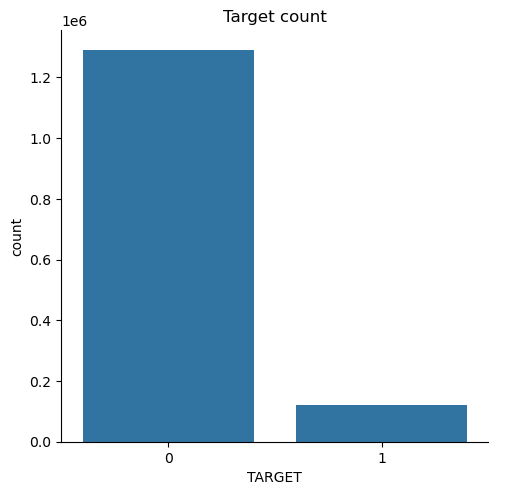

In [71]:
ax=sns.catplot(x="TARGET", kind="count", data=dd)
plt.title('Target count')
#Analysis:
#The people who are able to repay loan back is greater than 1200000 and people who have difficulty in paying loan back are less thant 1.5 L
#So it is clearly visible that the number of people who paid loan on time is much greater then the number of people had difficulty in paying loan back.


In [77]:
def missing_values(dd):
    # Get the missing values percentage in descending order
    mis_val = dd.isnull().sum()
    mis_val_percent = 100 * dd.isnull().sum() / len(dd)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    print(f"Dataframe has {dd.shape[1]} columns.\n"
          f"There are {mis_val_table_ren_columns.shape[0]} columns that have missing values.\n")

    # Count how many int, float, and object columns have missing values
    missing_int = mis_val_table_ren_columns[mis_val_table_ren_columns.index.isin(dd.select_dtypes(include='int').columns)].shape[0]
    missing_float = mis_val_table_ren_columns[mis_val_table_ren_columns.index.isin(dd.select_dtypes(include='float').columns)].shape[0]
    missing_object = mis_val_table_ren_columns[mis_val_table_ren_columns.index.isin(dd.select_dtypes(include='object').columns)].shape[0]

    print(f"\nNumber of columns with missing values by data type:")
    print(f"Int columns with missing values: {missing_int}")
    print(f"Float columns with missing values: {missing_float}")
    print(f"Object columns with missing values: {missing_object}")

    # Print the column names and their missing percentage for float and object types
    print("\nColumns with missing values and their missing percentage (for float and object types):")
    missing_float_and_object = mis_val_table_ren_columns[mis_val_table_ren_columns.index.isin(
        dd.select_dtypes(include=['float', 'object']).columns)]
    
    print(missing_float_and_object[['% of Total Values']])

    return mis_val_table_ren_columns


missing_values_data = missing_values(dd)



Dataframe has 158 columns.
There are 81 columns that have missing values.


Number of columns with missing values by data type:
Int columns with missing values: 0
Float columns with missing values: 73
Object columns with missing values: 8

Columns with missing values and their missing percentage (for float and object types):
                          % of Total Values
RATE_INTEREST_PRIMARY                  99.7
RATE_INTEREST_PRIVILEGED               99.7
COMMONAREA_MEDI                        69.7
COMMONAREA_MODE                        69.7
COMMONAREA_AVG                         69.7
...                                     ...
EXT_SOURCE_2                            0.1
AMT_GOODS_PRICE_x                       0.1
PRODUCT_COMBINATION                     0.0
AMT_ANNUITY_x                           0.0
AMT_CREDIT_y                            0.0

[81 rows x 1 columns]


In [83]:
#dropping columns which are 50% above null values

threshold =len(dd)*0.50
dd=dd.dropna(thresh=threshold,axis=1)

In [85]:

print("The datasize after dropping 50% of the null values: ",dd.shape )

The datasize after dropping 50% of the null values:  (1413701, 120)


In [89]:
dd.duplicated().sum()
print("THERE IS NO DUPLICATEED ENTRIES IN DATA", dd.duplicated().sum())

THERE IS NO DUPLICATEED ENTRIES IN DATA 0


In [91]:
# Check for null values in the data DataFrame
null_values_check = dd.isnull().sum()

# Print the number of missing values per column
print(null_values_check)

# Optionally, if you want to check if there are any columns left with missing values
if null_values_check.any():
    print("\nThere are still columns with missing values.")
else:
    print("\nThere are no missing values in the DataFrame.")

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE_x              0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
DAYS_FIRST_DUE               561106
DAYS_LAST_DUE_1ST_VERSION    561106
DAYS_LAST_DUE                561106
DAYS_TERMINATION             561106
NFLAG_INSURED_ON_APPROVAL    561106
Length: 120, dtype: int64

There are still columns with missing values.


In [93]:
# Identify categorical columns
categorical_cols = dd.select_dtypes(include=['object']).columns.tolist()

# Identify continuous columns (numeric features)
continuous_cols = dd.select_dtypes(include=['int64', 'float64']).columns.tolist()

# You can also manually filter out columns that should not be treated as categorical or continuous
# For example, columns like "SK_ID_CURR" might be identifiers, so you can remove them from categorical/continuous lists
categorical_cols = [col for col in categorical_cols if col != 'SK_ID_CURR']
continuous_cols = [col for col in continuous_cols if col != 'SK_ID_CURR']

# Display the results
print("Categorical Columns:")
print(categorical_cols)

print("\nContinuous Columns:")
print(continuous_cols)


print(f"\nTotal number of categorical columns: {len(categorical_cols)}")
print(f"\nTotal number of continuous columns: {len(continuous_cols)}")

Categorical Columns:
['NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'NAME_CONTRACT_TYPE_y', 'WEEKDAY_APPR_PROCESS_START_y', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE_y', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']

Continuous Columns:
['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAI

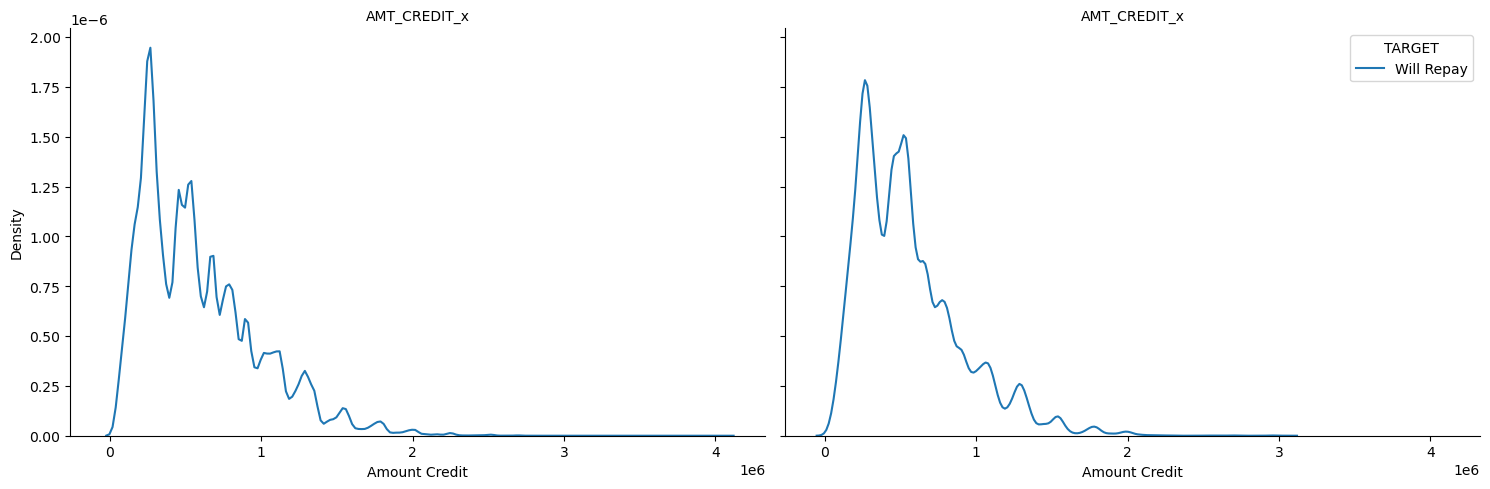

In [95]:
g = sns.FacetGrid(dd, col="TARGET", height=5, aspect=1.5)

g.map(sns.kdeplot, 'AMT_CREDIT_x')

g.set_axis_labels('Amount Credit', 'Density')  # Set labels for x and y
g.set_titles('AMT_CREDIT_x')  # Set the title for the grid
plt.legend(title="TARGET", labels=["Will Repay", "Will Default"])  # Optional legend
plt.show()

# PRE=PROCESSING THE CATEGORICAL COLUMNS

In [97]:
# Select object columns
object_columns = dd.select_dtypes(include=['object'])

# Print object column data types and null percentages
print("Columns with object data type:")
print(object_columns.dtypes)


# Calculate and print null percentage in each column
null_percentage = object_columns.isnull().mean() * 100  # Calculate null percentage
print("\nNull Percentage in each column:")
print(null_percentage)

Columns with object data type:
NAME_CONTRACT_TYPE_x            object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
NAME_TYPE_SUITE_x               object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
OCCUPATION_TYPE                 object
WEEKDAY_APPR_PROCESS_START_x    object
ORGANIZATION_TYPE               object
HOUSETYPE_MODE                  object
EMERGENCYSTATE_MODE             object
NAME_CONTRACT_TYPE_y            object
WEEKDAY_APPR_PROCESS_START_y    object
FLAG_LAST_APPL_PER_CONTRACT     object
NAME_CASH_LOAN_PURPOSE          object
NAME_CONTRACT_STATUS            object
NAME_PAYMENT_TYPE               object
CODE_REJECT_REASON              object
NAME_TYPE_SUITE_y               object
NAME_CLIENT_TYPE                object
NAME_GOODS_CATEGORY             object
NAME_PORTFOLIO                  o

In [37]:
# Handlinh missing values in categorical columns ------------------> 6 columns
# OCCUPATION_TYPE, NAME_TYPE_SUITE_x, HOUSETYPE_MODE, EMERGENCYSTATE_MODE, NAME_TYPE_SUITE_y, PRODUCT_COMBINATION 

In [99]:
dd["OCCUPATION_TYPE"].isnull().sum()

457580

In [101]:
# Calculate the mode of the column
mode_value = dd["OCCUPATION_TYPE"].mode()[0]
# Fill null values with the mode
dd["OCCUPATION_TYPE"].fillna(value=mode_value, inplace=True)


C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\4188799324.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dd["OCCUPATION_TYPE"].fillna(value=mode_value, inplace=True)
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\4188799324.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd["OCCUPATION_TYPE"].fillna(value=mode_value, i

In [103]:
dd["OCCUPATION_TYPE"].isnull().sum()

0

In [105]:
dd["HOUSETYPE_MODE"].isnull().sum()

704166

In [107]:
# Calculate the mode of the column
mode_value = dd["HOUSETYPE_MODE"].mode()[0]
# Fill null values with the mode
dd["HOUSETYPE_MODE"].fillna(value=mode_value, inplace=True)

C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\830994232.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dd["HOUSETYPE_MODE"].fillna(value=mode_value, inplace=True)
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\830994232.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd["HOUSETYPE_MODE"].fillna(value=mode_value, inpla

In [109]:
dd["HOUSETYPE_MODE"].isnull().sum()

0

In [111]:
dd["EMERGENCYSTATE_MODE"].isnull().sum()

665351

In [113]:
# Calculate the mode of the column
mode_value = dd["EMERGENCYSTATE_MODE"].mode()[0]
# Fill null values with the mode
dd["EMERGENCYSTATE_MODE"].fillna(value=mode_value, inplace=True)

C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\417847045.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dd["EMERGENCYSTATE_MODE"].fillna(value=mode_value, inplace=True)
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\417847045.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd["EMERGENCYSTATE_MODE"].fillna(value=mode_va

In [115]:
dd[categorical_cols].isnull().mean()*100

NAME_CONTRACT_TYPE_x             0.000000
CODE_GENDER                      0.000000
FLAG_OWN_CAR                     0.000000
FLAG_OWN_REALTY                  0.000000
NAME_TYPE_SUITE_x                0.249416
NAME_INCOME_TYPE                 0.000000
NAME_EDUCATION_TYPE              0.000000
NAME_FAMILY_STATUS               0.000000
NAME_HOUSING_TYPE                0.000000
OCCUPATION_TYPE                  0.000000
WEEKDAY_APPR_PROCESS_START_x     0.000000
ORGANIZATION_TYPE                0.000000
HOUSETYPE_MODE                   0.000000
EMERGENCYSTATE_MODE              0.000000
NAME_CONTRACT_TYPE_y             0.000000
WEEKDAY_APPR_PROCESS_START_y     0.000000
FLAG_LAST_APPL_PER_CONTRACT      0.000000
NAME_CASH_LOAN_PURPOSE           0.000000
NAME_CONTRACT_STATUS             0.000000
NAME_PAYMENT_TYPE                0.000000
CODE_REJECT_REASON               0.000000
NAME_TYPE_SUITE_y               49.138538
NAME_CLIENT_TYPE                 0.000000
NAME_GOODS_CATEGORY              0

In [119]:
dd[categorical_cols].isnull().mean()*100

NAME_CONTRACT_TYPE_x             0.000000
CODE_GENDER                      0.000000
FLAG_OWN_CAR                     0.000000
FLAG_OWN_REALTY                  0.000000
NAME_TYPE_SUITE_x                0.249416
NAME_INCOME_TYPE                 0.000000
NAME_EDUCATION_TYPE              0.000000
NAME_FAMILY_STATUS               0.000000
NAME_HOUSING_TYPE                0.000000
OCCUPATION_TYPE                  0.000000
WEEKDAY_APPR_PROCESS_START_x     0.000000
ORGANIZATION_TYPE                0.000000
HOUSETYPE_MODE                   0.000000
EMERGENCYSTATE_MODE              0.000000
NAME_CONTRACT_TYPE_y             0.000000
WEEKDAY_APPR_PROCESS_START_y     0.000000
FLAG_LAST_APPL_PER_CONTRACT      0.000000
NAME_CASH_LOAN_PURPOSE           0.000000
NAME_CONTRACT_STATUS             0.000000
NAME_PAYMENT_TYPE                0.000000
CODE_REJECT_REASON               0.000000
NAME_TYPE_SUITE_y               49.138538
NAME_CLIENT_TYPE                 0.000000
NAME_GOODS_CATEGORY              0

In [127]:
dd.drop(columns=["NAME_TYPE_SUITE_x", "NAME_TYPE_SUITE_y", "PRODUCT_COMBINATION"], inplace=True)


C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\2222777648.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd.drop(columns=["NAME_TYPE_SUITE_x", "NAME_TYPE_SUITE_y", "PRODUCT_COMBINATION"], inplace=True)


In [129]:
dd[categorical_cols].isnull().mean()*100

KeyError: "['NAME_TYPE_SUITE_x', 'NAME_TYPE_SUITE_y', 'PRODUCT_COMBINATION'] not in index"

In [135]:
print("The shape of the dd is:", dd.shape )

The shape of the dd is: (1413701, 117)


In [121]:
dd[continuous_cols].isnull().mean()*100

TARGET                        0.000000
CNT_CHILDREN                  0.000000
AMT_INCOME_TOTAL              0.000000
AMT_CREDIT_x                  0.000000
AMT_ANNUITY_x                 0.006578
                               ...    
DAYS_FIRST_DUE               39.690571
DAYS_LAST_DUE_1ST_VERSION    39.690571
DAYS_LAST_DUE                39.690571
DAYS_TERMINATION             39.690571
NFLAG_INSURED_ON_APPROVAL    39.690571
Length: 89, dtype: float64

In [133]:
missing_percentages = (dd[continuous_cols].isnull().mean() * 100).sort_values(ascending=False)
print(missing_percentages)


ENTRANCES_AVG       49.995155
ENTRANCES_MODE      49.995155
ENTRANCES_MEDI      49.995155
LIVINGAREA_AVG      49.826661
LIVINGAREA_MODE     49.826661
                      ...    
FLAG_DOCUMENT_10     0.000000
FLAG_DOCUMENT_11     0.000000
FLAG_DOCUMENT_12     0.000000
FLAG_DOCUMENT_13     0.000000
TARGET               0.000000
Length: 89, dtype: float64


In [139]:

missing_columns = [col for col in continuous_cols if dd[col].isnull().any()]
non_missing_columns = [col for col in continuous_cols if not dd[col].isnull().any()]


print("Columns with missing values:", missing_columns)
print("Columns without missing values:", non_missing_columns)


Columns with missing values: ['AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_ANNUITY_y', 'AMT_CREDIT_y', 'AMT_GOODS_PRICE_y', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']
Columns without missing values: ['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'REGION_POPULATION_RELATIVE', 'DAYS_B

In [141]:
percentage = (dd[missing_columns].isnull().mean() * 100).sort_values(ascending=False)
print(percentage)

ENTRANCES_MEDI                  49.995155
ENTRANCES_AVG                   49.995155
ENTRANCES_MODE                  49.995155
LIVINGAREA_MEDI                 49.826661
LIVINGAREA_AVG                  49.826661
LIVINGAREA_MODE                 49.826661
FLOORSMAX_MEDI                  49.409882
FLOORSMAX_MODE                  49.409882
FLOORSMAX_AVG                   49.409882
YEARS_BEGINEXPLUATATION_MEDI    48.431882
YEARS_BEGINEXPLUATATION_MODE    48.431882
YEARS_BEGINEXPLUATATION_AVG     48.431882
TOTALAREA_MODE                  47.926754
DAYS_LAST_DUE                   39.690571
DAYS_FIRST_DUE                  39.690571
DAYS_LAST_DUE_1ST_VERSION       39.690571
DAYS_FIRST_DRAWING              39.690571
NFLAG_INSURED_ON_APPROVAL       39.690571
DAYS_TERMINATION                39.690571
AMT_GOODS_PRICE_y               22.602021
AMT_ANNUITY_y                   21.731469
CNT_PAYMENT                     21.731116
EXT_SOURCE_3                    17.107012
AMT_REQ_CREDIT_BUREAU_HOUR      11

In [147]:
is_present = "EXT_SOURCE_1" in dd.columns
print(f"'EXT_SOURCE_1' column present in dd: {is_present}")


'EXT_SOURCE_1' column present in dd: False


# PRE=PROCESSING THE CONTINUOUS COLUMNS

In [150]:
 
# Check for unique values to play imputation
columns_to_check = [
    'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_MEDI', 'LIVINGAREA_AVG', 'LIVINGAREA_MODE',
    'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', 
    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE', 'DAYS_LAST_DUE', 
    'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_FIRST_DRAWING', 'NFLAG_INSURED_ON_APPROVAL', 
    'DAYS_TERMINATION', 'AMT_GOODS_PRICE_y', 'AMT_ANNUITY_y', 'CNT_PAYMENT', 'EXT_SOURCE_3', 
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 
    'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
    'OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE_x', 'AMT_ANNUITY_x', 'AMT_CREDIT_y'
]

# Print unique values for each column
for col in columns_to_check:
    print(f"Unique values in '{col}':\n{dd[col].unique()}\n")


Unique values in 'ENTRANCES_MEDI':
[0.069  0.0345    nan 0.2069 0.1379 0.1724 0.1034 0.1207 0.3103 0.4828
 0.3793 0.3448 0.2759 0.2414 0.1552 0.4483 0.0517 0.5172 0.1897 0.0862
 0.     0.4138 0.5517 0.2586 0.6207 0.6897 0.431  0.6552 0.5862 0.3276
 0.2241 0.7931 0.3621 0.8276 0.7586 0.4655 0.8621 1.     0.2931 0.8966
 0.9655 0.7241 0.5    0.931  0.569  0.3966 0.0172]

Unique values in 'ENTRANCES_AVG':
[0.069  0.0345    nan 0.2069 0.1379 0.1724 0.1034 0.1207 0.3103 0.4828
 0.3793 0.3448 0.1172 0.2759 0.1838 0.2414 0.1148 0.1552 0.4483 0.1262
 0.0517 0.5172 0.2528 0.1897 0.1607 0.0862 0.     0.2483 0.0917 0.0407
 0.4138 0.5517 0.2586 0.0948 0.1493 0.0759 0.6207 0.6897 0.1255 0.0841
 0.0572 0.1952 0.0897 0.2241 0.431  0.6552 0.1983 0.5862 0.3276 0.2845
 0.7931 0.3621 0.8276 0.1103 0.2183 0.0552 0.2138 0.7586 0.0803 0.2966
 0.0776 0.1466 0.4655 0.0903 0.1417 0.2345 0.8621 0.1586 0.1069 0.0738
 0.109  0.1931 0.1434 0.0914 0.4597 0.1448 0.1293 1.     0.1241 0.131
 0.2328 0.2931 0.2276 0.1352

In [152]:
# Fill with median ---->to reduce the skew
continuous_cols_to_fill = [
    'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_MEDI',
    'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE',
    'FLOORSMAX_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BEGINEXPLUATATION_AVG', 'TOTALAREA_MODE', 'DAYS_LAST_DUE', 'DAYS_FIRST_DUE',
    'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_FIRST_DRAWING', 'DAYS_TERMINATION', 
    'EXT_SOURCE_3', 'EXT_SOURCE_2'
]

for col in continuous_cols_to_fill:
    dd[col].fillna(dd[col].median(), inplace=True)  
#--------------------------------------------------------------------------------------------------------------------------    
# Replace with a logical default value
specific_cols_to_fill = ['NFLAG_INSURED_ON_APPROVAL', 'DEF_30_CNT_SOCIAL_CIRCLE', 
                         'DEF_60_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 
                         'OBS_30_CNT_SOCIAL_CIRCLE']

for col in specific_cols_to_fill:
    dd[col].fillna(0, inplace=True)  
#--------------------------------------------------------------------------------------------------------------------------    
# Replace with a business logic 
cols_to_fill_with_median = ['AMT_GOODS_PRICE_x', 'AMT_GOODS_PRICE_y', 'AMT_ANNUITY_x', 
                            'AMT_ANNUITY_y', 'CNT_PAYMENT', 'AMT_CREDIT_y']

for col in cols_to_fill_with_median:
    dd[col].fillna(dd[col].median(), inplace=True)
#--------------------------------------------------------------------------------------------------------------------------    
# fill missing values with 0 because missing values could indicate no requests were made.

credit_bureau_cols = [
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

for col in credit_bureau_cols:
    dd[col].fillna(0, inplace=True)


C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\919274953.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dd[col].fillna(dd[col].median(), inplace=True)
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\919274953.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd[col].fillna(dd[col].median(), inplace=True)
C:\Users\kanith

In [154]:
percentage = (dd[missing_columns].isnull().mean() * 100).sort_values(ascending=False)
print(percentage)

AMT_ANNUITY_x                   0.0
OBS_60_CNT_SOCIAL_CIRCLE        0.0
AMT_REQ_CREDIT_BUREAU_HOUR      0.0
AMT_REQ_CREDIT_BUREAU_DAY       0.0
AMT_REQ_CREDIT_BUREAU_WEEK      0.0
AMT_REQ_CREDIT_BUREAU_MON       0.0
AMT_REQ_CREDIT_BUREAU_QRT       0.0
AMT_REQ_CREDIT_BUREAU_YEAR      0.0
AMT_ANNUITY_y                   0.0
AMT_CREDIT_y                    0.0
AMT_GOODS_PRICE_y               0.0
CNT_PAYMENT                     0.0
DAYS_FIRST_DRAWING              0.0
DAYS_FIRST_DUE                  0.0
DAYS_LAST_DUE_1ST_VERSION       0.0
DAYS_LAST_DUE                   0.0
DAYS_TERMINATION                0.0
DEF_60_CNT_SOCIAL_CIRCLE        0.0
DEF_30_CNT_SOCIAL_CIRCLE        0.0
AMT_GOODS_PRICE_x               0.0
OBS_30_CNT_SOCIAL_CIRCLE        0.0
EXT_SOURCE_2                    0.0
EXT_SOURCE_3                    0.0
YEARS_BEGINEXPLUATATION_AVG     0.0
ENTRANCES_AVG                   0.0
FLOORSMAX_AVG                   0.0
LIVINGAREA_AVG                  0.0
YEARS_BEGINEXPLUATATION_MODE

In [158]:
missing_values = dd.isnull().sum()
missing_columns = missing_values[missing_values > 0]

if not missing_columns.empty:
    print("Columns with missing values:")
    print(missing_columns)
else:
    print("No missing values in the DataFrame.")


No missing values in the DataFrame.


In [160]:
print("HERE I CONCLUDE THERE IS NO MISSING VALUES IN THE DATAFRAME")

HERE I CONCLUDE THERE IS NO MISSING VALUES IN THE DATAFRAME


# FEATURE ENGINEERING

In [163]:
dd.shape

(1413701, 117)

In [169]:
dd.duplicated().sum()

0

In [177]:
# Identify categorical columns
categorical_cols = dd.select_dtypes(include=['object']).columns.tolist()

# Identify continuous columns (numeric features)
continuous_cols = dd.select_dtypes(include=['int64', 'float64']).columns.tolist()

# You can also manually filter out columns that should not be treated as categorical or continuous
# For example, columns like "SK_ID_CURR" might be identifiers, so you can remove them from categorical/continuous lists
categorical_cols = [col for col in categorical_cols if col != 'SK_ID_CURR']
continuous_cols = [col for col in continuous_cols if col != 'SK_ID_CURR']

# Display the results
print("Categorical Columns:")
print(categorical_cols)

print("\nContinuous Columns:")
print(continuous_cols)


print(f"\nTotal number of categorical columns: {len(categorical_cols)}")
print(f"\nTotal number of continuous columns: {len(continuous_cols)}")

Categorical Columns:
['NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'NAME_CONTRACT_TYPE_y', 'WEEKDAY_APPR_PROCESS_START_y', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP']

Continuous Columns:
['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLI

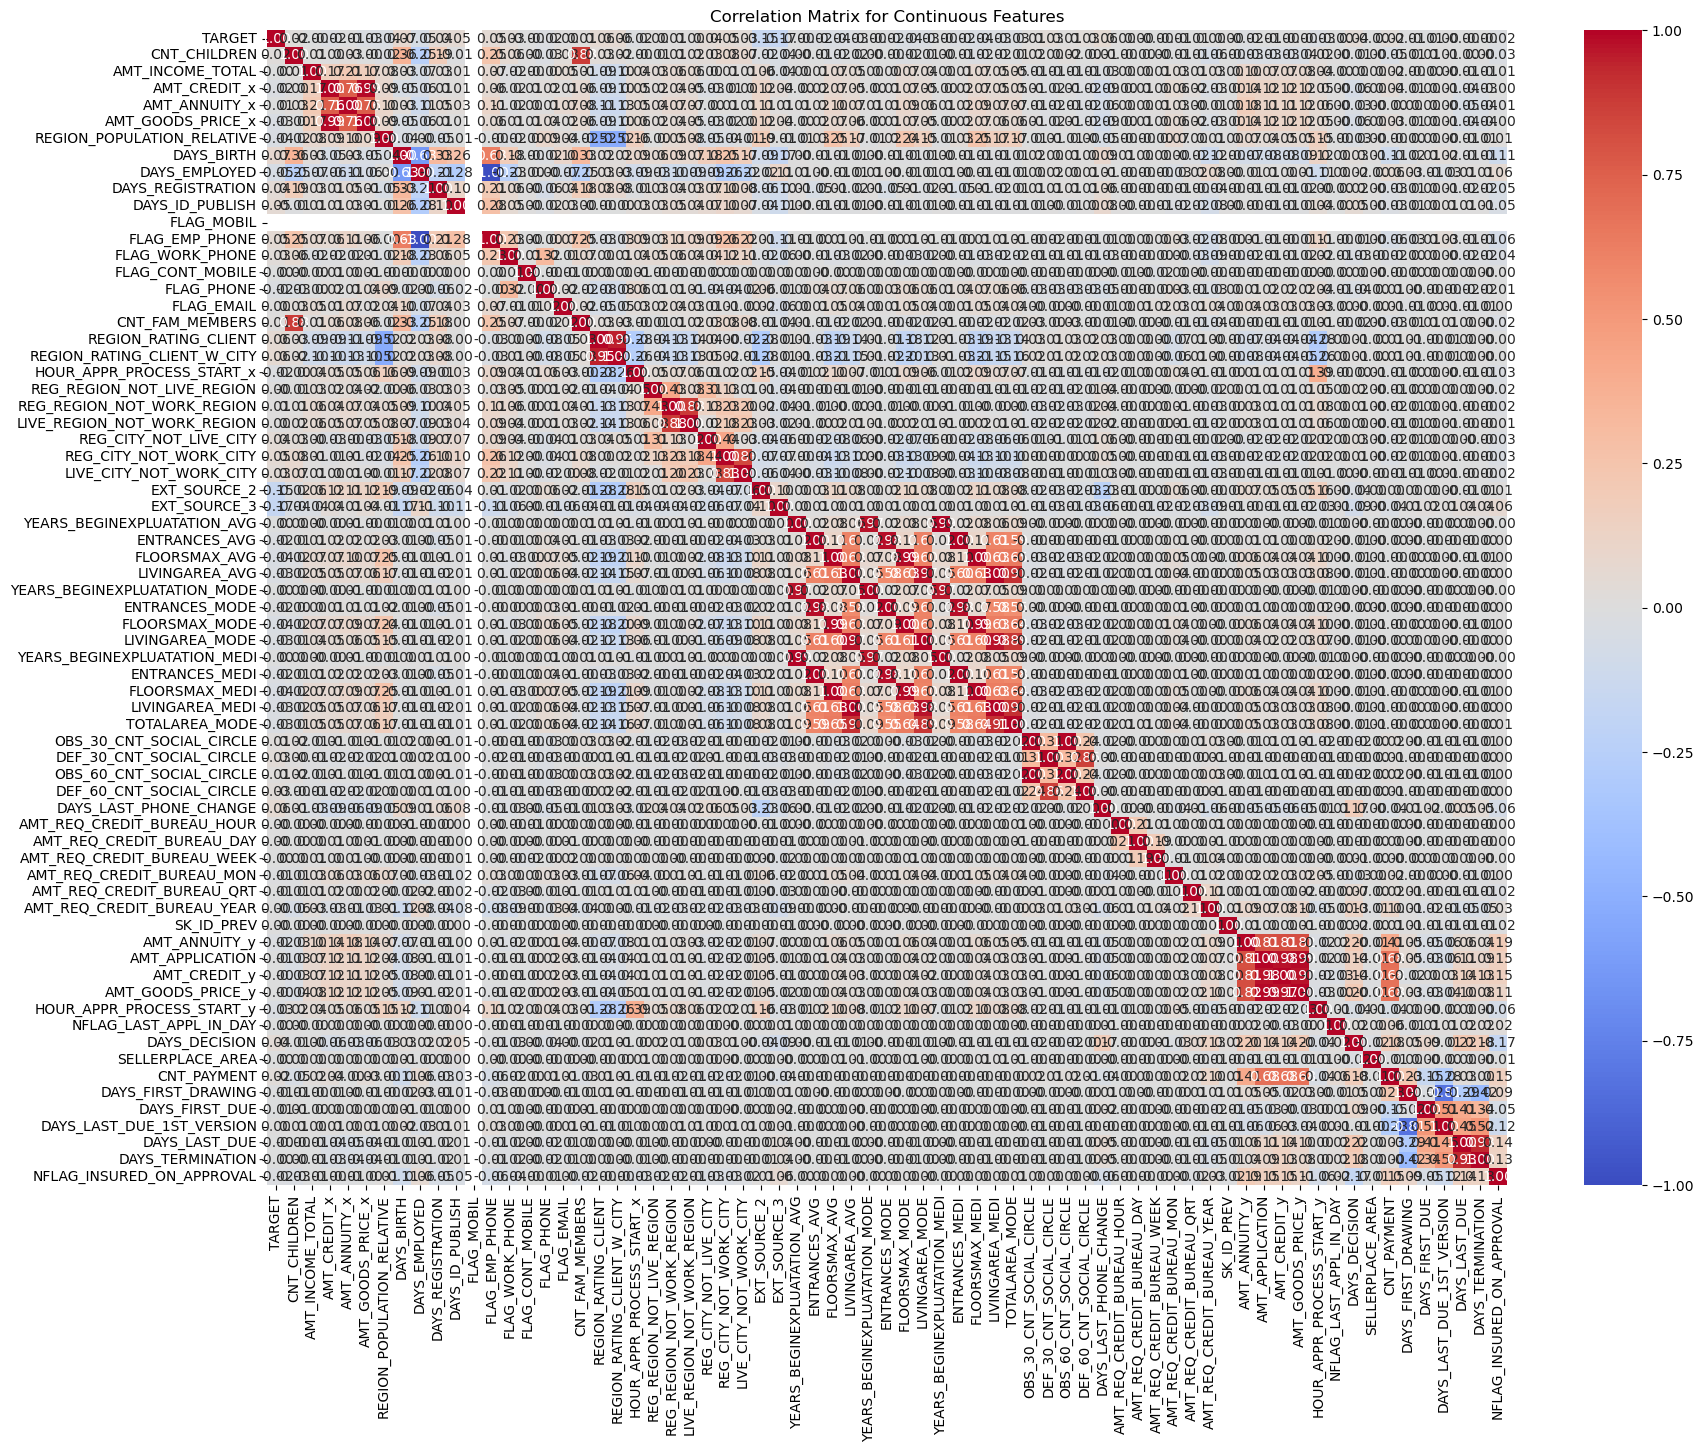

In [187]:

#correlation matrix
correlation_matrix_all = dd[continuous_columns].corr()

# Plot the heatmap to visualize the correlation matrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix_all, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Continuous Features')
plt.show()


In [193]:
# Displaying the column names along with the total number of columns BEFORE FEATURE ENGINERRING
print("Number of columns:", len(dd.columns))
print("Columns names:", dd.columns.tolist())


Number of columns: 117
Columns names: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MO

In [195]:
# 1. Date-based features (assuming days are negative, indicating age or duration)
dd['AGE'] = dd['DAYS_BIRTH'] / -365  # Converting age in years
dd['TENURE'] = dd['DAYS_EMPLOYED'] / -365  # Employment tenure in years
dd['REGISTRATION_AGE'] = dd['DAYS_REGISTRATION'] / -365  # Registration age in years
dd['ID_AGE'] = dd['DAYS_ID_PUBLISH'] / -365  # ID age in years
dd['PHONE_CHANGE_AGE'] = dd['DAYS_LAST_PHONE_CHANGE'] / -365  # Phone change age in years

C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1559213998.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['AGE'] = dd['DAYS_BIRTH'] / -365  # Converting age in years
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1559213998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TENURE'] = dd['DAYS_EMPLOYED'] / -365  # Employment tenure in years
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1559213998.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [201]:
# 2. Tenure-based features
import numpy as np
dd['TENURE'] = dd['DAYS_EMPLOYED'] / -365  # Employment tenure in years
dd['TENURE_CATEGORY'] = pd.cut(dd['TENURE'], bins=[0, 1, 3, 5, np.inf], labels=['<1 year', '1-3 years', '3-5 years', '5+ years'])
dd['TENURE_LOW'] = (dd['TENURE'] < 1).astype(int)  # Flag for low tenure (<1 year)
dd['CURRENT_EMPLOYED'] = (dd['DAYS_EMPLOYED'] > 0).astype(int)  # Flag for currently employed

C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1738716295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TENURE'] = dd['DAYS_EMPLOYED'] / -365  # Employment tenure in years
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1738716295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['TENURE_CATEGORY'] = pd.cut(dd['TENURE'], bins=[0, 1, 3, 5, np.inf], labels=['<1 year', '1-3 years', '3-5 years', '5+ years'])
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1738716295.py:5: Se

In [203]:
# 3. Registration Age (time since registration)
dd['REGISTRATION_AGE'] = dd['DAYS_REGISTRATION'] / -365  # Registration age in years
dd['REGISTRATION_CATEGORY'] = pd.cut(dd['REGISTRATION_AGE'], bins=[0, 1, 3, 5, np.inf], labels=['<1 year', '1-3 years', '3-5 years', '5+ years'])
dd['RECENT_REGISTRATION'] = (dd['REGISTRATION_AGE'] < 1).astype(int)  # Flag for recent registration (<1 year)


C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\2669595982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['REGISTRATION_AGE'] = dd['DAYS_REGISTRATION'] / -365  # Registration age in years
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\2669595982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['REGISTRATION_CATEGORY'] = pd.cut(dd['REGISTRATION_AGE'], bins=[0, 1, 3, 5, np.inf], labels=['<1 year', '1-3 years', '3-5 years', '5+ years'])
C:\Users\kanith1234\AppData\Local\Temp\ipyker

In [205]:
# 4. ID Age (time since ID publication)
dd['ID_AGE'] = dd['DAYS_ID_PUBLISH'] / -365  # ID age in years
dd['ID_RECENCY'] = (dd['ID_AGE'] < 5).astype(int)  # Flag for ID published in the last 5 years

# 5. Phone Change Age (time since phone number change)
dd['PHONE_CHANGE_AGE'] = dd['DAYS_LAST_PHONE_CHANGE'] / -365  # Phone change age in years
dd['PHONE_CHANGE_RECENT'] = (dd['PHONE_CHANGE_AGE'] < 1).astype(int)  # Flag for recent phone change (<1 year)

C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\3526643068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['ID_AGE'] = dd['DAYS_ID_PUBLISH'] / -365  # ID age in years
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\3526643068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['ID_RECENCY'] = (dd['ID_AGE'] < 5).astype(int)  # Flag for ID published in the last 5 years
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\3526643068.py:6: SettingWithCopyWarning: 
A value is trying to 

In [207]:
# Displaying the column names along with the total number of columns BEFORE FEATURE ENGINERRING
print("Number of columns:", len(dd.columns))
print("Columns names:", dd.columns.tolist())

Number of columns: 129
Columns names: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MO

In [211]:
# 2. Social Circle features (30 days)
dd['SOCIAL_CIRCLE_RATIO'] = dd['OBS_30_CNT_SOCIAL_CIRCLE'] / (dd['DEF_30_CNT_SOCIAL_CIRCLE'] + 1)  # Avoid division by 0
dd['SOCIAL_CIRCLE_RATIO_60'] = dd['OBS_60_CNT_SOCIAL_CIRCLE'] / (dd['DEF_60_CNT_SOCIAL_CIRCLE'] + 1)

C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1158332772.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['SOCIAL_CIRCLE_RATIO'] = dd['OBS_30_CNT_SOCIAL_CIRCLE'] / (dd['DEF_30_CNT_SOCIAL_CIRCLE'] + 1)  # Avoid division by 0
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1158332772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['SOCIAL_CIRCLE_RATIO_60'] = dd['OBS_60_CNT_SOCIAL_CIRCLE'] / (dd['DEF_60_CNT_SOCIAL_CIRCLE'] + 1)


In [213]:
# 3. Credit and Loan-related features
dd['LOAN_TO_INCOME'] = dd['AMT_CREDIT_x'] / dd['AMT_INCOME_TOTAL']  # Loan to income ratio
dd['LOAN_TO_ASSET'] = dd['AMT_CREDIT_x'] / dd['AMT_GOODS_PRICE_x']  # Loan to asset ratio
dd['ANNUITY_TO_INCOME'] = dd['AMT_ANNUITY_x'] / dd['AMT_INCOME_TOTAL']  # Annuity to income ratio

C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\3660961882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['LOAN_TO_INCOME'] = dd['AMT_CREDIT_x'] / dd['AMT_INCOME_TOTAL']  # Loan to income ratio
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\3660961882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['LOAN_TO_ASSET'] = dd['AMT_CREDIT_x'] / dd['AMT_GOODS_PRICE_x']  # Loan to asset ratio
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\3660961882.py:4: SettingWithCopyWarning:

In [215]:
# 4. Cyclical features for time-based columns (e.g., HOUR_APPR_PROCESS_START_x)
dd['SIN_HOUR'] = np.sin(dd['HOUR_APPR_PROCESS_START_x'] * (2 * np.pi / 24))  # Sine transformation for hours
dd['COS_HOUR'] = np.cos(dd['HOUR_APPR_PROCESS_START_x'] * (2 * np.pi / 24))  # Cosine transformation for hours

C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1743186206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['SIN_HOUR'] = np.sin(dd['HOUR_APPR_PROCESS_START_x'] * (2 * np.pi / 24))  # Sine transformation for hours
C:\Users\kanith1234\AppData\Local\Temp\ipykernel_16736\1743186206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['COS_HOUR'] = np.cos(dd['HOUR_APPR_PROCESS_START_x'] * (2 * np.pi / 24))  # Cosine transformation for hours


In [217]:
# Displaying the column names along with the total number of columns BEFORE FEATURE ENGINERRING
print("Number of columns:", len(dd.columns))
print("Columns names:", dd.columns.tolist())

Number of columns: 136
Columns names: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MO

In [219]:
(dd[['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']]==1).sum(axis=0)

FLAG_DOCUMENT_2         100
FLAG_DOCUMENT_3     1044103
FLAG_DOCUMENT_4         108
FLAG_DOCUMENT_5       19362
FLAG_DOCUMENT_6      126417
FLAG_DOCUMENT_7         301
FLAG_DOCUMENT_8      105215
FLAG_DOCUMENT_9        4499
FLAG_DOCUMENT_10         79
FLAG_DOCUMENT_11       2407
FLAG_DOCUMENT_12          2
FLAG_DOCUMENT_13       2522
FLAG_DOCUMENT_14       2020
FLAG_DOCUMENT_15        929
FLAG_DOCUMENT_16       8491
FLAG_DOCUMENT_17        201
FLAG_DOCUMENT_18       5932
FLAG_DOCUMENT_19        564
FLAG_DOCUMENT_20        519
FLAG_DOCUMENT_21        317
dtype: int64

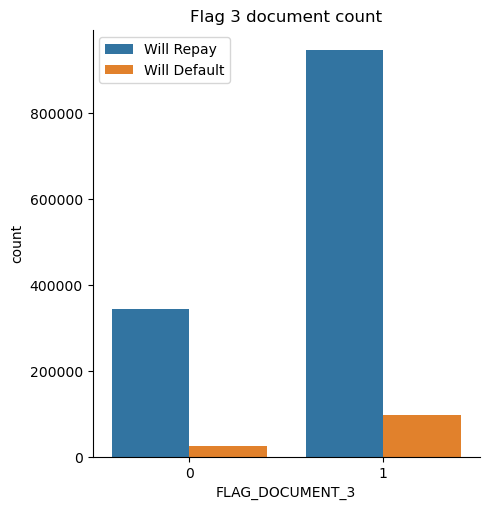

In [221]:
sns.catplot(x="FLAG_DOCUMENT_3", kind="count",hue='TARGET', data=dd,legend=False)
plt.title('Flag 3 document count')
plt.legend(labels=['Will Repay', 'Will Default'])

In [ ]:
#Both type of clients mostly submit only 1 document which is document 3.
#FLAG_DOCUMENT_3 is the most common document submited by the applicants.
#FLAG_DOCUMENT_3 is mostly submited by the clients who can repay the laon and not submited by the clients who cannot repay the loan but this could be also possible because the data is imbalanced.

In [ ]:
# Redundant AMT columns, --------highly correlated columns, they might contribute redundant information, leading to overfitting.
# AMT_CREDIT_x, or AMT_CREDIT_y
# AMT_GOODS_PRICE_x, or AMT_GOODS_PRICE_y.
# AMT_ANNUITY_x, or AMT_ANNUITY_y.


# DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH: These columns are all representing durations, so they may be highly correlated. 
#  (AGE, TENURE, REGISTRATION_AGE, ID_AGE) ----> original columns


# Derived features from others
#'TENURE_CATEGORY', 'TENURE_LOW', 'CURRENT_EMPLOYED', 'REGISTRATION_CATEGORY', 'RECENT_REGISTRATION', 'ID_RECENCY', 'PHONE_CHANGE_RECENT'

# others 
# NAME_SELLER_INDUSTRY, NAME_CONTRACT_TYPE_y,'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',

In [223]:
# Displaying the column names along with the total number of columns BEFORE FEATURE ENGINERRING
print("Number of columns:", len(dd.columns))
print("Columns names:", dd.columns.tolist())

Number of columns: 136
Columns names: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MO

In [225]:
# Dropping the specified columns from the 'dd' DataFrame
columns_to_drop = ['TENURE_CATEGORY', 'TENURE_LOW', 'CURRENT_EMPLOYED', 'REGISTRATION_CATEGORY', 
                   'RECENT_REGISTRATION', 'ID_RECENCY', 'PHONE_CHANGE_RECENT',

                   
                   'FLAG_DOCUMENT_2','FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
                   'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 
                   'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12','FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
                   'FLAG_DOCUMENT_15','FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
                   'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
                      
                   'AMT_CREDIT_y', 'AMT_GOODS_PRICE_y', 'AMT_ANNUITY_y',
                  'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
                  
                  'TENURE_CATEGORY', 'TENURE_LOW', 'CURRENT_EMPLOYED', 'REGISTRATION_CATEGORY', 
                   'RECENT_REGISTRATION', 'ID_RECENCY', 'PHONE_CHANGE_RECENT',
                  'NAME_SELLER_INDUSTRY', 'NAME_CONTRACT_TYPE_y','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

dd = dd.drop(columns=columns_to_drop)

# Verify if the columns are dropped
print(dd.columns.tolist())


['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_INCOME_TYPE', 'REGION_POPULATION_RELATIVE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE', 'TOTALAREA

In [ ]:
#45 columns are removed 

In [227]:
# Displaying the column names along with the total number of columns BEFORE FEATURE ENGINERRING
print("Number of columns:", len(dd.columns))
print("Columns names:", dd.columns.tolist())

Number of columns: 98
Columns names: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_INCOME_TYPE', 'REGION_POPULATION_RELATIVE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGARE

In [231]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413701 entries, 0 to 1413700
Data columns (total 98 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   SK_ID_CURR                    1413701 non-null  int64  
 1   TARGET                        1413701 non-null  int64  
 2   NAME_CONTRACT_TYPE_x          1413701 non-null  object 
 3   CODE_GENDER                   1413701 non-null  object 
 4   FLAG_OWN_CAR                  1413701 non-null  object 
 5   FLAG_OWN_REALTY               1413701 non-null  object 
 6   CNT_CHILDREN                  1413701 non-null  int64  
 7   AMT_INCOME_TOTAL              1413701 non-null  float64
 8   AMT_CREDIT_x                  1413701 non-null  float64
 9   AMT_ANNUITY_x                 1413701 non-null  float64
 10  AMT_GOODS_PRICE_x             1413701 non-null  float64
 11  NAME_INCOME_TYPE              1413701 non-null  object 
 12  REGION_POPULATION_RELATIVE  

In [233]:
# Identify categorical columns
categorical_cols = dd.select_dtypes(include=['object']).columns.tolist()

# Identify continuous columns (numeric features)
continuous_cols = dd.select_dtypes(include=['int64', 'float64']).columns.tolist()

# You can also manually filter out columns that should not be treated as categorical or continuous
# For example, columns like "SK_ID_CURR" might be identifiers, so you can remove them from categorical/continuous lists
categorical_cols = [col for col in categorical_cols if col != 'SK_ID_CURR']
continuous_cols = [col for col in continuous_cols if col != 'SK_ID_CURR']

# Display the results
print("Categorical Columns:")
print(categorical_cols)

print("\nContinuous Columns:")
print(continuous_cols)


print(f"\nTotal number of categorical columns: {len(categorical_cols)}")
print(f"\nTotal number of continuous columns: {len(continuous_cols)}")

Categorical Columns:
['NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'WEEKDAY_APPR_PROCESS_START_y', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP']

Continuous Columns:
['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 

In [ ]:
# Still to reduce the redendency we can remove columns 

In [237]:
dd.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
       'NAME_INCOME_TYPE', 'REGION_POPULATION_RELATIVE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'ENTRANCES_MODE',
       'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGI

In [239]:
# Displaying the column names along with the total number of columns BEFORE FEATURE ENGINERRING
print("Number of columns:", len(dd.columns))
print("Columns names:", dd.columns.tolist())

Number of columns: 98
Columns names: ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_INCOME_TYPE', 'REGION_POPULATION_RELATIVE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGARE

In [249]:
# List of columns to drop
columns_to_drop_still = [
    
    'WEEKDAY_APPR_PROCESS_START_y',  # Duplicate of WEEKDAY_APPR_PROCESS_START_x
    'HOUR_APPR_PROCESS_START_y',  # Duplicate of HOUR_APPR_PROCESS_START_x
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',  # Similar region/city features

    'SELLERPLACE_AREA',  # Possibly low impact or redundant
    
    'DAYS_LAST_PHONE_CHANGE',  # Already captured in PHONE_CHANGE_AGE
 
    
    
    'NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL',  # Potentially low importance
]

# Drop columns directly from the dataframe (inplace=True)
dd.drop(columns=columns_to_drop_still, inplace=True)

# Check the resulting dataframe
print(dd.head())


   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE_x CODE_GENDER FLAG_OWN_CAR  \
0      100002       1           Cash loans           M            N   
1      100003       0           Cash loans           F            N   
2      100003       0           Cash loans           F            N   
3      100003       0           Cash loans           F            N   
4      100004       0      Revolving loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0               Y             0          202500.0      406597.5   
1               N             0          270000.0     1293502.5   
2               N             0          270000.0     1293502.5   
3               N             0          270000.0     1293502.5   
4               Y             0           67500.0      135000.0   

   AMT_ANNUITY_x  ...  REGISTRATION_AGE    ID_AGE  PHONE_CHANGE_AGE  \
0        24700.5  ...          9.994521  5.808219          3.106849   
1        35698.5  ...       

In [259]:
# List of columns to drop
columns_to_drop_stilll = [
    'OBS_30_CNT_SOCIAL_CIRCLE', 
    'DEF_30_CNT_SOCIAL_CIRCLE', 
    'OBS_60_CNT_SOCIAL_CIRCLE', 
    'DEF_60_CNT_SOCIAL_CIRCLE'
]

# Drop columns directly from the dataframe (inplace=True)
dd.drop(columns=columns_to_drop_stilll, inplace=True, errors='ignore')

In [261]:
print("Number of columns:", len(dd.columns))

Number of columns: 82


In [265]:
# Identify categorical columns
categorical_cols = dd.select_dtypes(include=['object']).columns.tolist()

# Identify continuous columns (numeric features)
continuous_cols = dd.select_dtypes(include=['int64', 'float64']).columns.tolist()

# You can also manually filter out columns that should not be treated as categorical or continuous
# For example, columns like "SK_ID_CURR" might be identifiers, so you can remove them from categorical/continuous lists
categorical_cols = [col for col in categorical_cols if col != 'SK_ID_CURR']
continuous_cols = [col for col in continuous_cols if col != 'SK_ID_CURR']

# Display the results
print("Categorical Columns:")
print(categorical_cols)

print("\nContinuous Columns:")
print(continuous_cols)


print(f"\nTotal number of categorical columns: {len(categorical_cols)}")
print(f"\nTotal number of continuous columns: {len(continuous_cols)}")

Categorical Columns:
['NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP']

Continuous Columns:
['TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_x', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'ENTRANCES_MODE', 'FLOORSMAX

# FINALLY AFTER THE FEATURE ENGINEERING WE GOT 82 COLUMNS IN TOTAL DATAFRAME

# 21----> CATEGORICAL COLUMNS 
# 60----> NUMERICAL COLUMNS

In [269]:
dd.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE_x CODE_GENDER FLAG_OWN_CAR  \
0      100002       1           Cash loans           M            N   
1      100003       0           Cash loans           F            N   
2      100003       0           Cash loans           F            N   
3      100003       0           Cash loans           F            N   
4      100004       0      Revolving loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT_x  \
0               Y             0          202500.0      406597.5   
1               N             0          270000.0     1293502.5   
2               N             0          270000.0     1293502.5   
3               N             0          270000.0     1293502.5   
4               Y             0           67500.0      135000.0   

   AMT_ANNUITY_x  ...  REGISTRATION_AGE    ID_AGE  PHONE_CHANGE_AGE  \
0        24700.5  ...          9.994521  5.808219          3.106849   
1        35698.5  ...          3.249315  0.797260          2.268493   
2        35698.5  ...          3.249315  0.797260          2.268493   
3        35698.5  ...          3.249315  0.797260          2.268493   
4         6750.0  ...         11.671233  6.934247          2.232877   

   SOCIAL_CIRCLE_RATIO  SOCIAL_CIRCLE_RATIO_60  LOAN_TO_INCOME  LOAN_TO_ASSET  \
0             0.666667                0.666667        2.007889       1.158397   
1             1.000000                1.000000        4.790750       1.145199   
2             1.000000                1.000000        4.790750       1.145199   
3             1.000000                1.000000        4.790750       1.145199   
4             0.000000                0.000000        2.000000       1.000000   

   ANNUITY_TO_INCOME  SIN_HOUR  COS_HOUR  
0           0.121978  0.500000 -0.866025  
1           0.132217  0.258819 -0.965926  
2           0.132217  0.258819 -0.965926  
3           0.132217  0.258819 -0.965926  
4           0.100000  0.707107 -0.707107  

[5 rows x 82 columns]

In [271]:
dd.shape

(1413701, 82)

In [273]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413701 entries, 0 to 1413700
Data columns (total 82 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   SK_ID_CURR                    1413701 non-null  int64  
 1   TARGET                        1413701 non-null  int64  
 2   NAME_CONTRACT_TYPE_x          1413701 non-null  object 
 3   CODE_GENDER                   1413701 non-null  object 
 4   FLAG_OWN_CAR                  1413701 non-null  object 
 5   FLAG_OWN_REALTY               1413701 non-null  object 
 6   CNT_CHILDREN                  1413701 non-null  int64  
 7   AMT_INCOME_TOTAL              1413701 non-null  float64
 8   AMT_CREDIT_x                  1413701 non-null  float64
 9   AMT_ANNUITY_x                 1413701 non-null  float64
 10  AMT_GOODS_PRICE_x             1413701 non-null  float64
 11  NAME_INCOME_TYPE              1413701 non-null  object 
 12  REGION_POPULATION_RELATIVE  

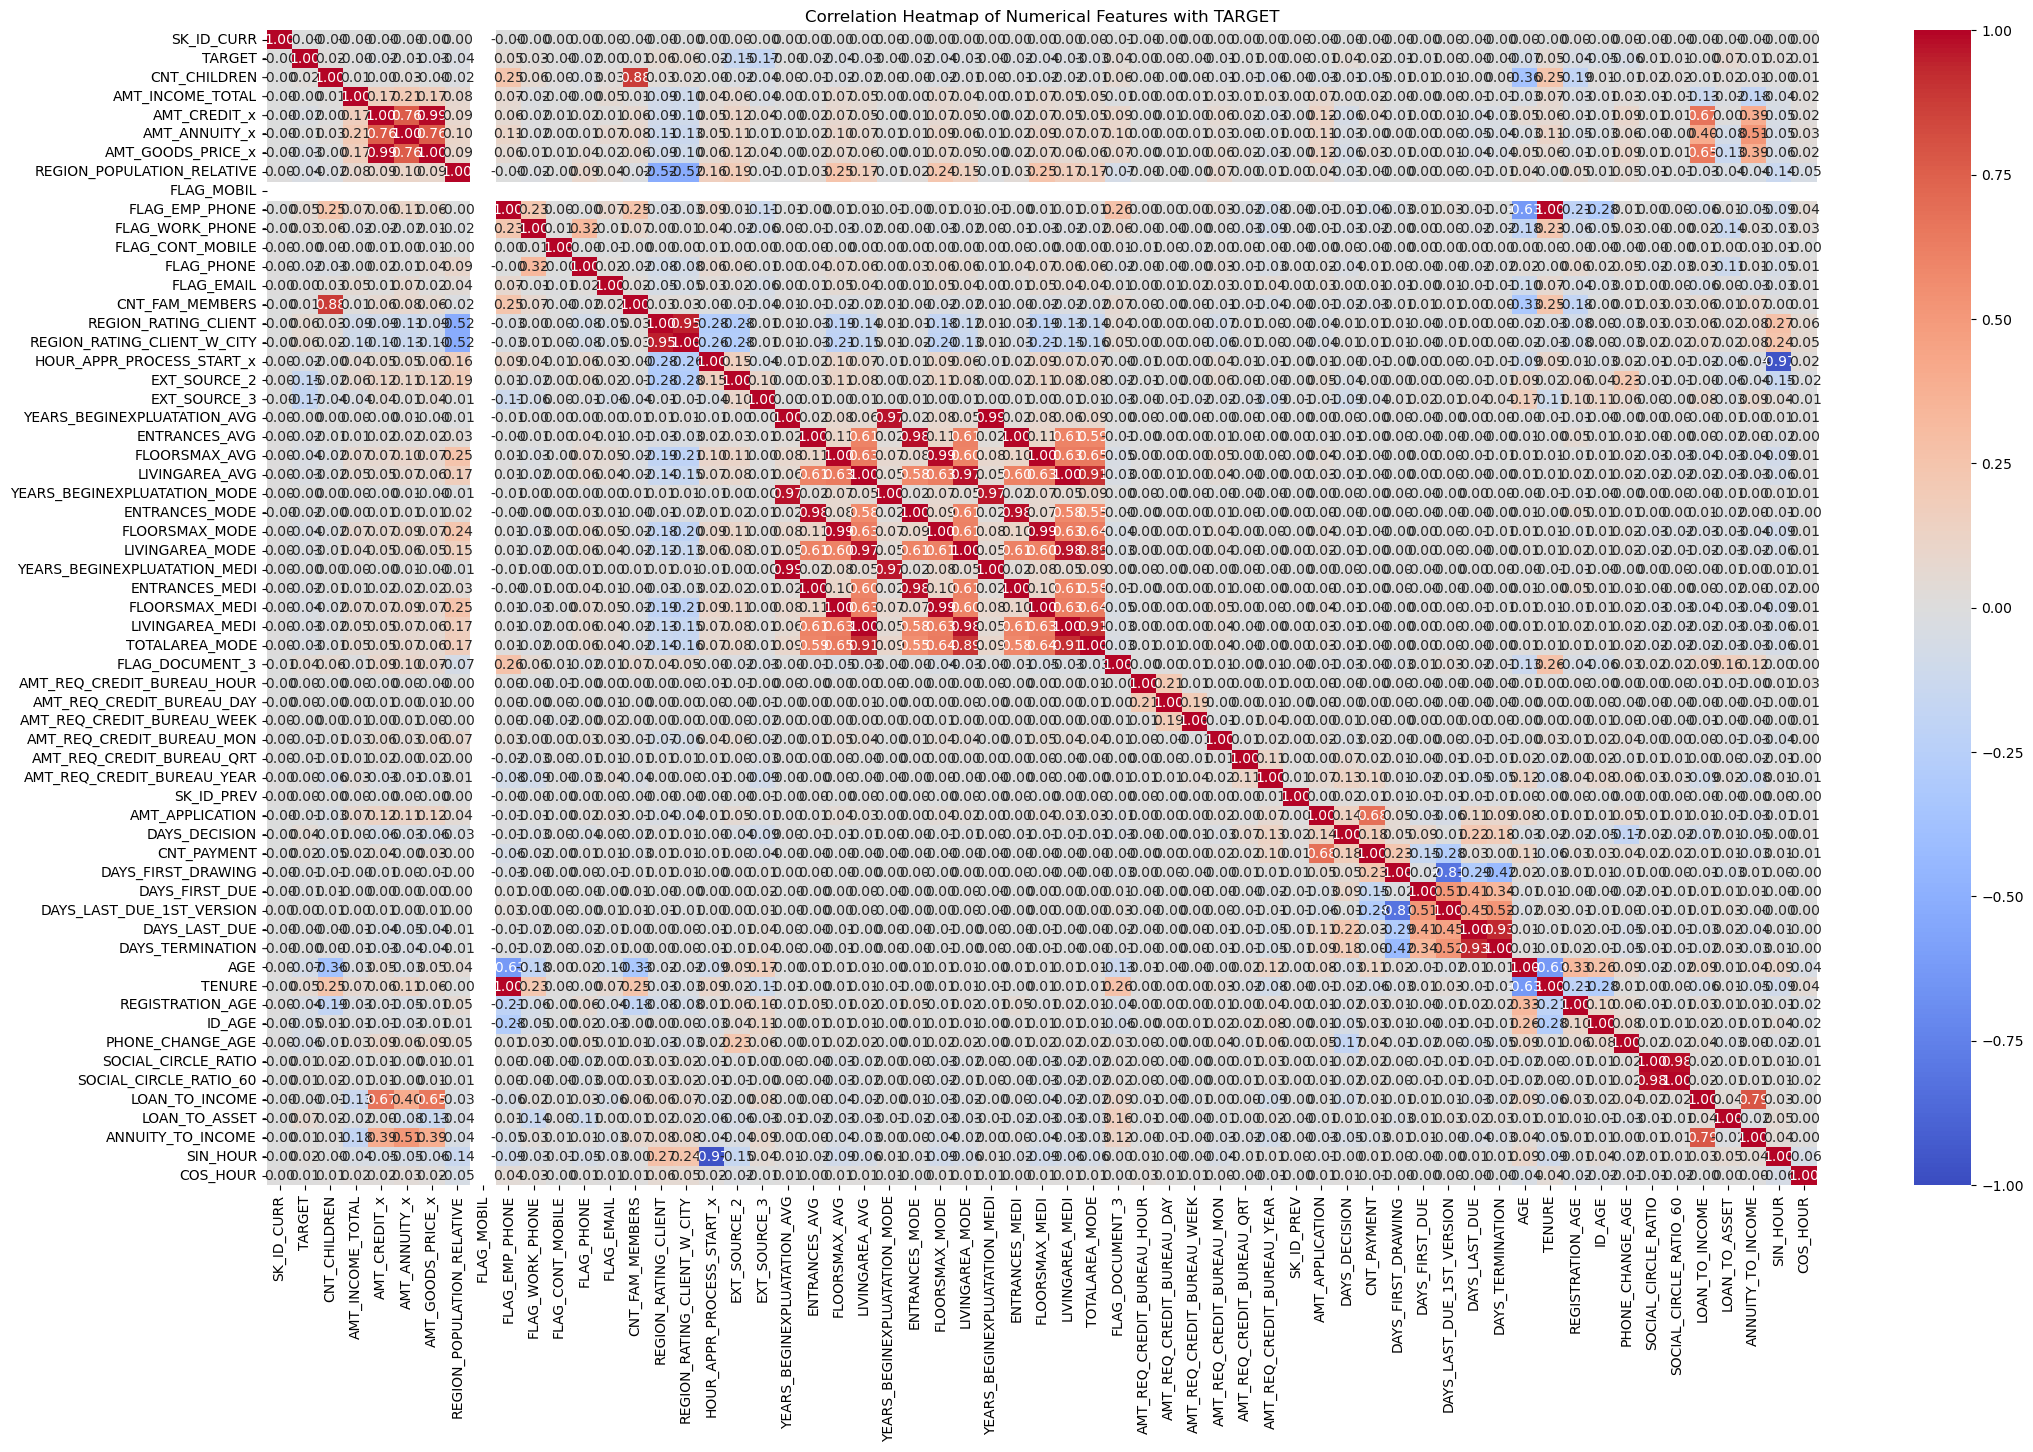

TARGET                         1.000000
LOAN_TO_ASSET                  0.065939
REGION_RATING_CLIENT_W_CITY    0.059700
REGION_RATING_CLIENT           0.056932
FLAG_EMP_PHONE                 0.048750
                                 ...   
PHONE_CHANGE_AGE              -0.059721
AGE                           -0.074866
EXT_SOURCE_2                  -0.154906
EXT_SOURCE_3                  -0.168595
FLAG_MOBIL                          NaN
Name: TARGET, Length: 61, dtype: float64


In [279]:


# Select only numeric columns (int and float) from the dataframe
numeric_cols = dd.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix for numeric columns with respect to 'TARGET'
corr_matrix = dd[numeric_cols].corr()

# Get the correlation of all columns with 'TARGET'
target_corr = corr_matrix['TARGET'].sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Heatmap of Numerical Features with TARGET')
plt.show()

# Display the target correlations
print(target_corr)


In [283]:

n = 20  # You can adjust this number as needed

# Get top n positive correlations (excluding TARGET itself)
positive_corr = target_corr.tail(n)
# Get top n negative correlations (excluding TARGET itself)
negative_corr = target_corr.head(n)

# Print the positive and negative correlations
print(f'{n} Positive Correlations with TARGET:\n', positive_corr)
print(f'\n{n} Negative Correlations with TARGET:\n', negative_corr)

20 Positive Correlations with TARGET:
 ENTRANCES_AVG                -0.016891
FLAG_PHONE                   -0.021385
HOUR_APPR_PROCESS_START_x    -0.022448
AMT_CREDIT_x                 -0.023622
LIVINGAREA_MODE              -0.027137
LIVINGAREA_MEDI              -0.028510
LIVINGAREA_AVG               -0.028661
TOTALAREA_MODE               -0.029228
AMT_GOODS_PRICE_x            -0.032562
REGION_POPULATION_RELATIVE   -0.035028
FLOORSMAX_MODE               -0.035881
FLOORSMAX_MEDI               -0.036597
FLOORSMAX_AVG                -0.036962
REGISTRATION_AGE             -0.043123
ID_AGE                       -0.051037
PHONE_CHANGE_AGE             -0.059721
AGE                          -0.074866
EXT_SOURCE_2                 -0.154906
EXT_SOURCE_3                 -0.168595
FLAG_MOBIL                         NaN
Name: TARGET, dtype: float64

20 Negative Correlations with TARGET:
 TARGET                         1.000000
LOAN_TO_ASSET                  0.065939
REGION_RATING_CLIENT_W_CITY    0

In [293]:
# List of columns to drop
columns_to_drop_stilll = [
 'ENTRANCES_AVG','HOUR_APPR_PROCESS_START_x','CNT_CHILDREN','SOCIAL_CIRCLE_RATIO_60','REGION_RATING_CLIENT_W_CITY','REGION_POPULATION_RELATIVE','FLAG_MOBIL',
'LOAN_TO_INCOME'
]

# Drop columns directly from the dataframe (inplace=True)
dd.drop(columns=columns_to_drop_stilll, inplace=True, errors='ignore')

In [295]:
dd.shape

(1413701, 74)

In [289]:

categorical_columns = [
    'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 
    'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 
    'EMERGENCYSTATE_MODE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 
    'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 
    'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP'
]

# Get the unique values in each categorical column
unique_values = {col: dd[col].unique() for col in categorical_columns}
unique_values


{'NAME_CONTRACT_TYPE_x': array(['Cash loans', 'Revolving loans'], dtype=object),
 'CODE_GENDER': array(['M', 'F', 'XNA'], dtype=object),
 'FLAG_OWN_CAR': array(['N', 'Y'], dtype=object),
 'FLAG_OWN_REALTY': array(['Y', 'N'], dtype=object),
 'NAME_INCOME_TYPE': array(['Working', 'State servant', 'Commercial associate', 'Pensioner',
        'Unemployed', 'Student', 'Maternity leave'], dtype=object),
 'OCCUPATION_TYPE': array(['Laborers', 'Core staff', 'Accountants', 'Managers', 'Drivers',
        'Sales staff', 'Cleaning staff', 'Private service staff',
        'Medicine staff', 'Security staff', 'Cooking staff',
        'High skill tech staff', 'Waiters/barmen staff',
        'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff',
        'HR staff'], dtype=object),
 'WEEKDAY_APPR_PROCESS_START_x': array(['WEDNESDAY', 'MONDAY', 'THURSDAY', 'SUNDAY', 'SATURDAY', 'FRIDAY',
        'TUESDAY'], dtype=object),
 'ORGANIZATION_TYPE': array(['Business Entity Type 3', 'School', 'Govern

In [291]:
# List of categorical columns
categorical_columns = [
    'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 
    'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 
    'EMERGENCYSTATE_MODE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 
    'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 
    'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP'
]

# Check for any null values in the categorical columns
null_values = {col: dd[col].isnull().sum() for col in categorical_columns}

# Print the null values for each categorical column
print(null_values)


{'NAME_CONTRACT_TYPE_x': 0, 'CODE_GENDER': 0, 'FLAG_OWN_CAR': 0, 'FLAG_OWN_REALTY': 0, 'NAME_INCOME_TYPE': 0, 'OCCUPATION_TYPE': 0, 'WEEKDAY_APPR_PROCESS_START_x': 0, 'ORGANIZATION_TYPE': 0, 'HOUSETYPE_MODE': 0, 'EMERGENCYSTATE_MODE': 0, 'FLAG_LAST_APPL_PER_CONTRACT': 0, 'NAME_CASH_LOAN_PURPOSE': 0, 'NAME_CONTRACT_STATUS': 0, 'NAME_PAYMENT_TYPE': 0, 'CODE_REJECT_REASON': 0, 'NAME_CLIENT_TYPE': 0, 'NAME_GOODS_CATEGORY': 0, 'NAME_PORTFOLIO': 0, 'NAME_PRODUCT_TYPE': 0, 'CHANNEL_TYPE': 0, 'NAME_YIELD_GROUP': 0}


# ENCODING

In [300]:
dd.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE_x CODE_GENDER FLAG_OWN_CAR  \
0      100002       1           Cash loans           M            N   
1      100003       0           Cash loans           F            N   
2      100003       0           Cash loans           F            N   
3      100003       0           Cash loans           F            N   
4      100004       0      Revolving loans           M            Y   

  FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY_x  \
0               Y          202500.0      406597.5        24700.5   
1               N          270000.0     1293502.5        35698.5   
2               N          270000.0     1293502.5        35698.5   
3               N          270000.0     1293502.5        35698.5   
4               Y           67500.0      135000.0         6750.0   

   AMT_GOODS_PRICE_x  ...        AGE    TENURE  REGISTRATION_AGE    ID_AGE  \
0           351000.0  ...  25.920548  1.745205          9.994521  5.808219   
1          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
2          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
3          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
4           135000.0  ...  52.180822  0.616438         11.671233  6.934247   

   PHONE_CHANGE_AGE  SOCIAL_CIRCLE_RATIO LOAN_TO_ASSET  ANNUITY_TO_INCOME  \
0          3.106849             0.666667      1.158397           0.121978   
1          2.268493             1.000000      1.145199           0.132217   
2          2.268493             1.000000      1.145199           0.132217   
3          2.268493             1.000000      1.145199           0.132217   
4          2.232877             0.000000      1.000000           0.100000   

   SIN_HOUR  COS_HOUR  
0  0.500000 -0.866025  
1  0.258819 -0.965926  
2  0.258819 -0.965926  
3  0.258819 -0.965926  
4  0.707107 -0.707107  

[5 rows x 74 columns]

In [302]:

categorical_columns = [
    'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 
    'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 
    'EMERGENCYSTATE_MODE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 
    'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 
    'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP'
]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    # Fill missing values with the mode (most frequent value) of the column
    mode_value = dd[col].mode()[0]  # Mode is the most frequent value
    dd[col] = dd[col].fillna(mode_value)
    
    # Label encode the column
    dd[col] = label_encoder.fit_transform(dd[col])

# Now, the categorical columns will have been label encoded and NaNs filled with mode values


In [304]:
dd.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                     0            1             0   
1      100003       0                     0            0             0   
2      100003       0                     0            0             0   
3      100003       0                     0            0             0   
4      100004       0                     1            1             1   

   FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY_x  \
0                1          202500.0      406597.5        24700.5   
1                0          270000.0     1293502.5        35698.5   
2                0          270000.0     1293502.5        35698.5   
3                0          270000.0     1293502.5        35698.5   
4                1           67500.0      135000.0         6750.0   

   AMT_GOODS_PRICE_x  ...        AGE    TENURE  REGISTRATION_AGE    ID_AGE  \
0           351000.0  ...  25.920548  1.745205          9.994521  5.808219   
1          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
2          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
3          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
4           135000.0  ...  52.180822  0.616438         11.671233  6.934247   

   PHONE_CHANGE_AGE  SOCIAL_CIRCLE_RATIO  LOAN_TO_ASSET  ANNUITY_TO_INCOME  \
0          3.106849             0.666667       1.158397           0.121978   
1          2.268493             1.000000       1.145199           0.132217   
2          2.268493             1.000000       1.145199           0.132217   
3          2.268493             1.000000       1.145199           0.132217   
4          2.232877             0.000000       1.000000           0.100000   

   SIN_HOUR  COS_HOUR  
0  0.500000 -0.866025  
1  0.258819 -0.965926  
2  0.258819 -0.965926  
3  0.258819 -0.965926  
4  0.707107 -0.707107  

[5 rows x 74 columns]

In [371]:
import pickle

# Save the 'dd' dataframe to a pickle file
with open('label_encoded_data.pkl', 'wb') as file:
    pickle.dump(dd, file)

print("Data saved to 'label_encoded_data.pkl'")


Data saved to 'label_encoded_data.pkl'


In [308]:
dd.duplicated().sum()

0

In [310]:
# Identify categorical columns
categorical_cols = dd.select_dtypes(include=['object']).columns.tolist()

# Identify continuous columns (numeric features)
continuous_cols = dd.select_dtypes(include=['int64', 'float64']).columns.tolist()

# You can also manually filter out columns that should not be treated as categorical or continuous
# For example, columns like "SK_ID_CURR" might be identifiers, so you can remove them from categorical/continuous lists
categorical_cols = [col for col in categorical_cols if col != 'SK_ID_CURR']
continuous_cols = [col for col in continuous_cols if col != 'SK_ID_CURR']

# Display the results
print("Categorical Columns:")
print(categorical_cols)

print("\nContinuous Columns:")
print(continuous_cols)


print(f"\nTotal number of categorical columns: {len(categorical_cols)}")
print(f"\nTotal number of continuous columns: {len(continuous_cols)}")

Categorical Columns:
[]

Continuous Columns:
['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'YEARS_BEGINEXPLUATATION_AVG', 'FLOORSMAX_AVG', 'LIVINGAREA_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'TOTALAREA_MODE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'SK_ID_PREV', 'AMT_APPLICATION', 'DAYS_DECISION', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'AGE', 'TENURE', 'REGISTRATION_AGE', 'ID_AGE', 'PHONE_CHANGE_AGE', 'SOCIAL_CIRCLE_RAT

In [312]:
dd.shape

(1413701, 74)

In [314]:
dd.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                     0            1             0   
1      100003       0                     0            0             0   
2      100003       0                     0            0             0   
3      100003       0                     0            0             0   
4      100004       0                     1            1             1   

   FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY_x  \
0                1          202500.0      406597.5        24700.5   
1                0          270000.0     1293502.5        35698.5   
2                0          270000.0     1293502.5        35698.5   
3                0          270000.0     1293502.5        35698.5   
4                1           67500.0      135000.0         6750.0   

   AMT_GOODS_PRICE_x  ...        AGE    TENURE  REGISTRATION_AGE    ID_AGE  \
0           351000.0  ...  25.920548  1.745205          9.994521  5.808219   
1          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
2          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
3          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
4           135000.0  ...  52.180822  0.616438         11.671233  6.934247   

   PHONE_CHANGE_AGE  SOCIAL_CIRCLE_RATIO  LOAN_TO_ASSET  ANNUITY_TO_INCOME  \
0          3.106849             0.666667       1.158397           0.121978   
1          2.268493             1.000000       1.145199           0.132217   
2          2.268493             1.000000       1.145199           0.132217   
3          2.268493             1.000000       1.145199           0.132217   
4          2.232877             0.000000       1.000000           0.100000   

   SIN_HOUR  COS_HOUR  
0  0.500000 -0.866025  
1  0.258819 -0.965926  
2  0.258819 -0.965926  
3  0.258819 -0.965926  
4  0.707107 -0.707107  

[5 rows x 74 columns]

In [316]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413701 entries, 0 to 1413700
Data columns (total 74 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   SK_ID_CURR                    1413701 non-null  int64  
 1   TARGET                        1413701 non-null  int64  
 2   NAME_CONTRACT_TYPE_x          1413701 non-null  int32  
 3   CODE_GENDER                   1413701 non-null  int32  
 4   FLAG_OWN_CAR                  1413701 non-null  int32  
 5   FLAG_OWN_REALTY               1413701 non-null  int32  
 6   AMT_INCOME_TOTAL              1413701 non-null  float64
 7   AMT_CREDIT_x                  1413701 non-null  float64
 8   AMT_ANNUITY_x                 1413701 non-null  float64
 9   AMT_GOODS_PRICE_x             1413701 non-null  float64
 10  NAME_INCOME_TYPE              1413701 non-null  int32  
 11  FLAG_EMP_PHONE                1413701 non-null  int64  
 12  FLAG_WORK_PHONE             

In [318]:
ss = dd.copy()

In [320]:
ss.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                     0            1             0   
1      100003       0                     0            0             0   
2      100003       0                     0            0             0   
3      100003       0                     0            0             0   
4      100004       0                     1            1             1   

   FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY_x  \
0                1          202500.0      406597.5        24700.5   
1                0          270000.0     1293502.5        35698.5   
2                0          270000.0     1293502.5        35698.5   
3                0          270000.0     1293502.5        35698.5   
4                1           67500.0      135000.0         6750.0   

   AMT_GOODS_PRICE_x  ...        AGE    TENURE  REGISTRATION_AGE    ID_AGE  \
0           351000.0  ...  25.920548  1.745205          9.994521  5.808219   
1          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
2          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
3          1129500.0  ...  45.931507  3.254795          3.249315  0.797260   
4           135000.0  ...  52.180822  0.616438         11.671233  6.934247   

   PHONE_CHANGE_AGE  SOCIAL_CIRCLE_RATIO  LOAN_TO_ASSET  ANNUITY_TO_INCOME  \
0          3.106849             0.666667       1.158397           0.121978   
1          2.268493             1.000000       1.145199           0.132217   
2          2.268493             1.000000       1.145199           0.132217   
3          2.268493             1.000000       1.145199           0.132217   
4          2.232877             0.000000       1.000000           0.100000   

   SIN_HOUR  COS_HOUR  
0  0.500000 -0.866025  
1  0.258819 -0.965926  
2  0.258819 -0.965926  
3  0.258819 -0.965926  
4  0.707107 -0.707107  

[5 rows x 74 columns]

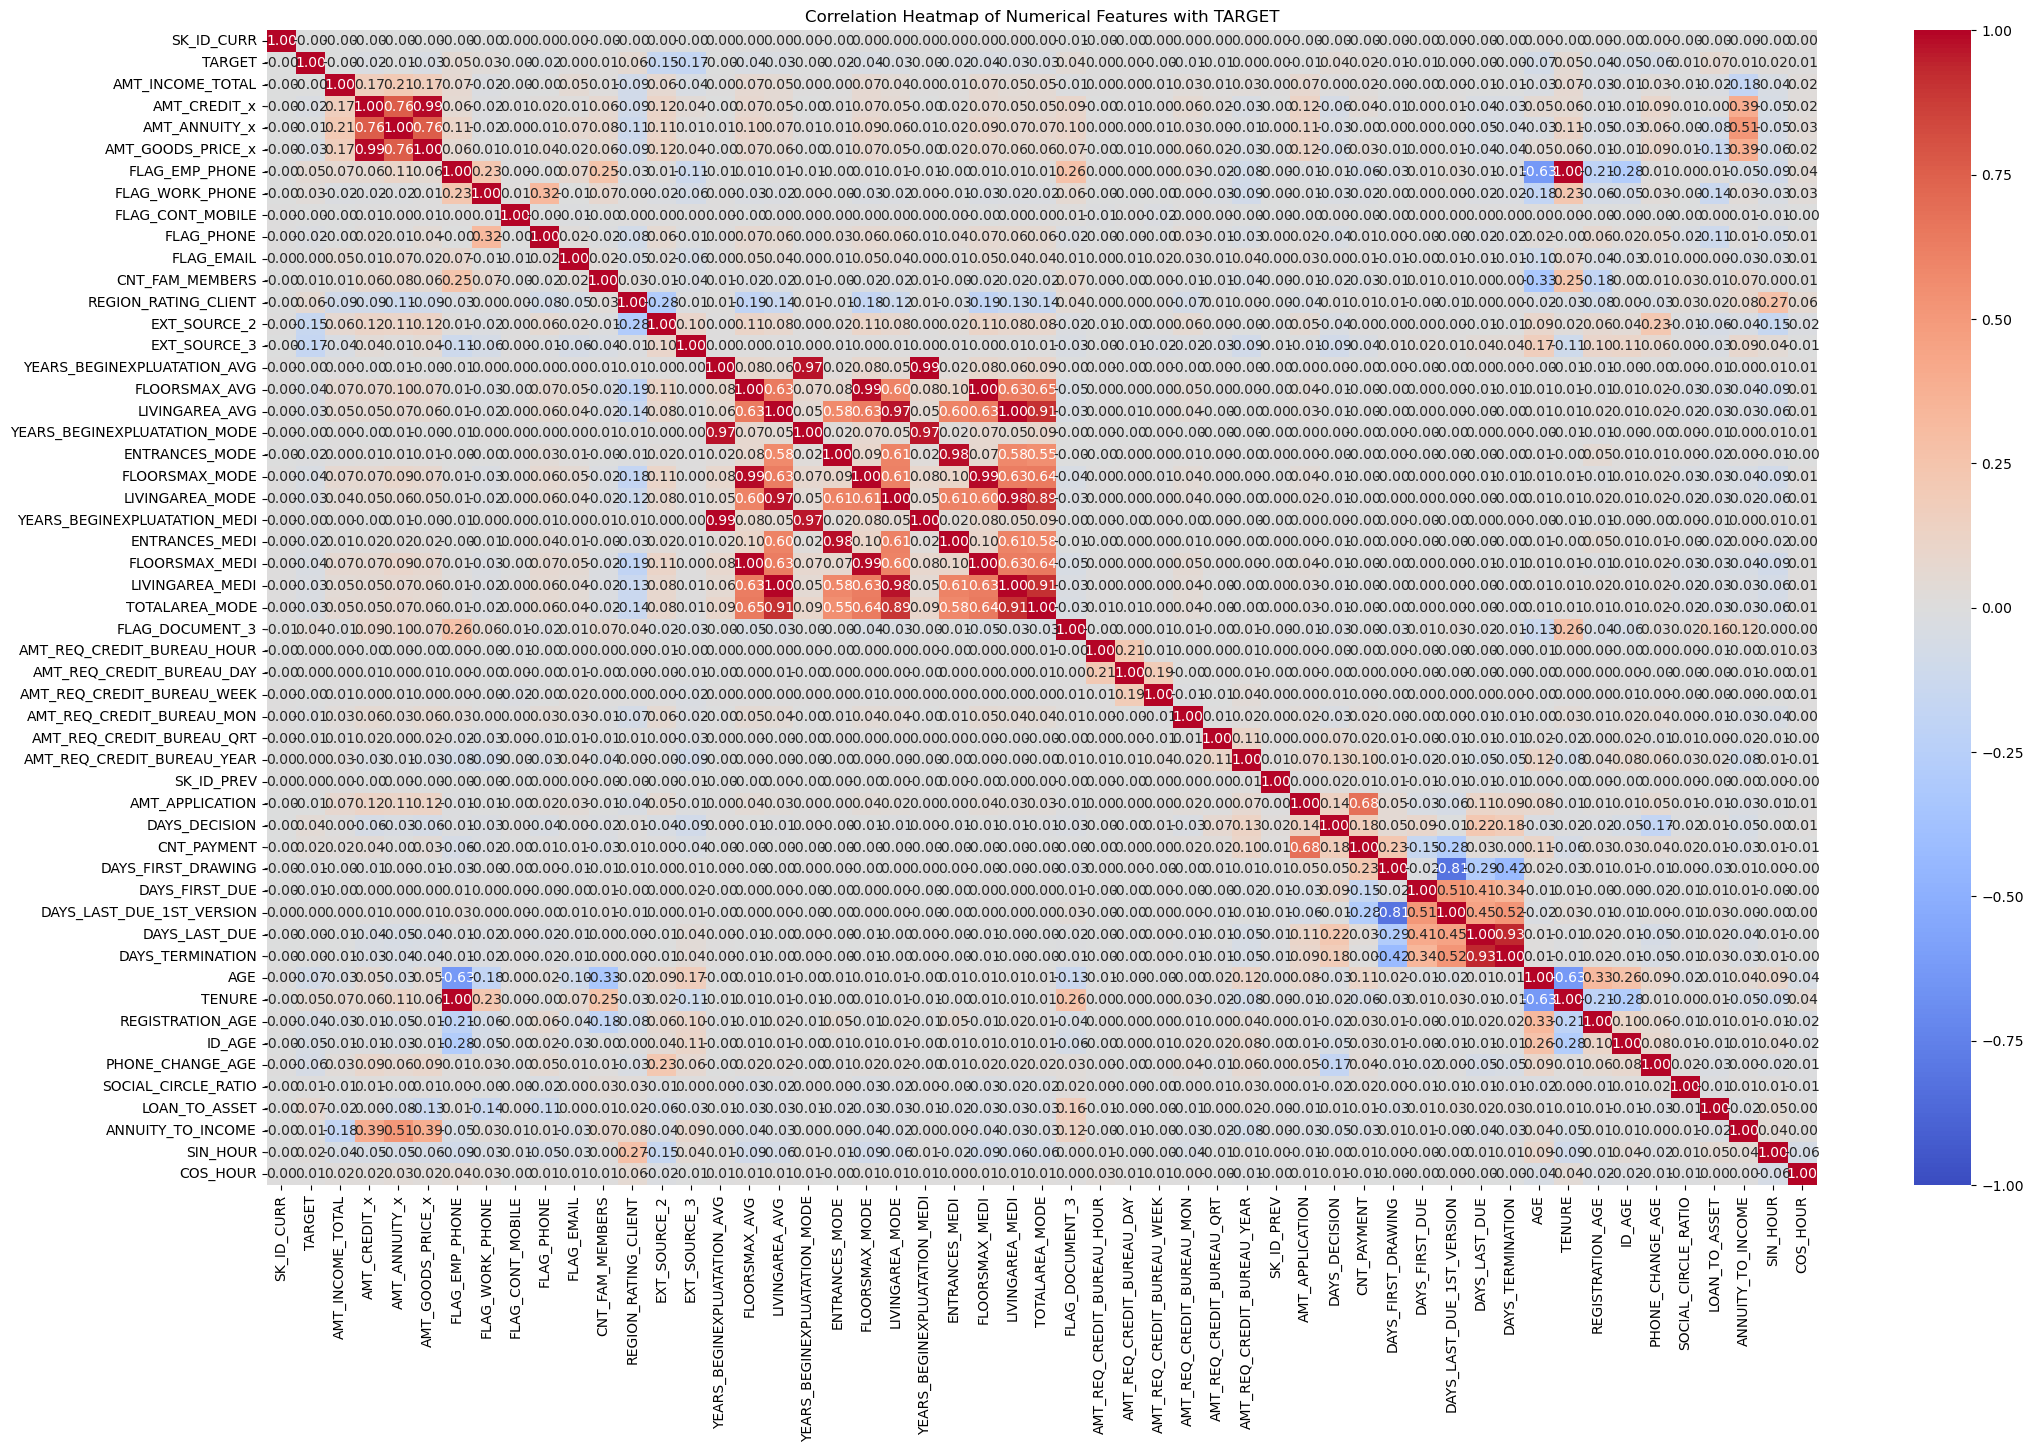

TARGET                          1.000000
LOAN_TO_ASSET                   0.065939
REGION_RATING_CLIENT            0.056932
FLAG_EMP_PHONE                  0.048750
TENURE                          0.047804
FLAG_DOCUMENT_3                 0.041918
DAYS_DECISION                   0.039901
FLAG_WORK_PHONE                 0.028261
CNT_PAYMENT                     0.023689
SIN_HOUR                        0.020610
CNT_FAM_MEMBERS                 0.014847
ANNUITY_TO_INCOME               0.012797
SOCIAL_CIRCLE_RATIO             0.007216
COS_HOUR                        0.005046
AMT_REQ_CREDIT_BUREAU_DAY       0.004027
DAYS_LAST_DUE_1ST_VERSION       0.003775
AMT_REQ_CREDIT_BUREAU_YEAR      0.002091
FLAG_EMAIL                      0.002063
SK_ID_PREV                      0.002009
AMT_REQ_CREDIT_BUREAU_HOUR      0.000224
FLAG_CONT_MOBILE               -0.000059
AMT_REQ_CREDIT_BUREAU_WEEK     -0.000696
SK_ID_CURR                     -0.001246
AMT_INCOME_TOTAL               -0.002152
DAYS_LAST_DUE   

In [322]:
# Select only numeric columns (int and float) from the dataframe
numeric_cols = ss.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix for numeric columns with respect to 'TARGET'
corr_matrix = ss[numeric_cols].corr()

# Get the correlation of all columns with 'TARGET'
target_corr = corr_matrix['TARGET'].sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Heatmap of Numerical Features with TARGET')
plt.show()

# Display the target correlations
print(target_corr)


In [332]:
# List of columns to drop
final_dropz= [
'YEARS_BEGINEXPLUATATION_AVG','FLAG_EMP_PHONE','AMT_GOODS_PRICE_x','DAYS_LAST_DUE_1ST_VERSION','AMT_APPLICATION','CNT_FAM_MEMBERS','AMT_REQ_CREDIT_BUREAU_HOUR',
]

# Drop columns directly from the dataframe (inplace=True)
ss.drop(columns=final_dropz, inplace=True, errors='ignore')

In [334]:
# List of columns to drop
final_dropz= [
'YEARS_BEGINEXPLUATATION_MODE','LIVINGAREA_MODE','LIVINGAREA_AVG','YEARS_BEGINEXPLUATATION_AVG','ENTRANCES_MODE','FLOORSMAX_MODE','YEARS_BEGINEXPLUATATION_MEDI',
    'AMT_REQ_CREDIT_BUREAU_HOUR','REGISTRATION_AGE',
]

# Drop columns directly from the dataframe (inplace=True)
ss.drop(columns=final_dropz, inplace=True, errors='ignore')

In [348]:
# # List of columns to drop
# final_dropz= [
# 'FLOORSMAX_MEDI','ENTRANCES_MEDI','AMT_CERDIT_x','LOAN_TO_ASSET'
# ]

# # Drop columns directly from the dataframe (inplace=True)
# ss.drop(columns=final_dropz, inplace=True, errors='ignore')



# # List of columns to drop
# final_dropz= [
# 'ANNUITY_TO_INCOME','AMT_CERDIT_x'
# ]

# # Drop columns directly from the dataframe (inplace=True)
# ss.drop(columns=final_dropz, inplace=True, errors='ignore')

In [352]:
# List of columns to drop
final_dropz= [
'LIVINGAREA_AVG','FLAG_PHONE', 
]

# Drop columns directly from the dataframe (inplace=True)
ss.drop(columns=final_dropz, inplace=True, errors='ignore')

In [356]:
# List of columns to drop
final_dropz= [
'LIVINGAREA_MEDI', 'TOTALAREA_MODE'
]

# Drop columns directly from the dataframe (inplace=True)
ss.drop(columns=final_dropz, inplace=True, errors='ignore')

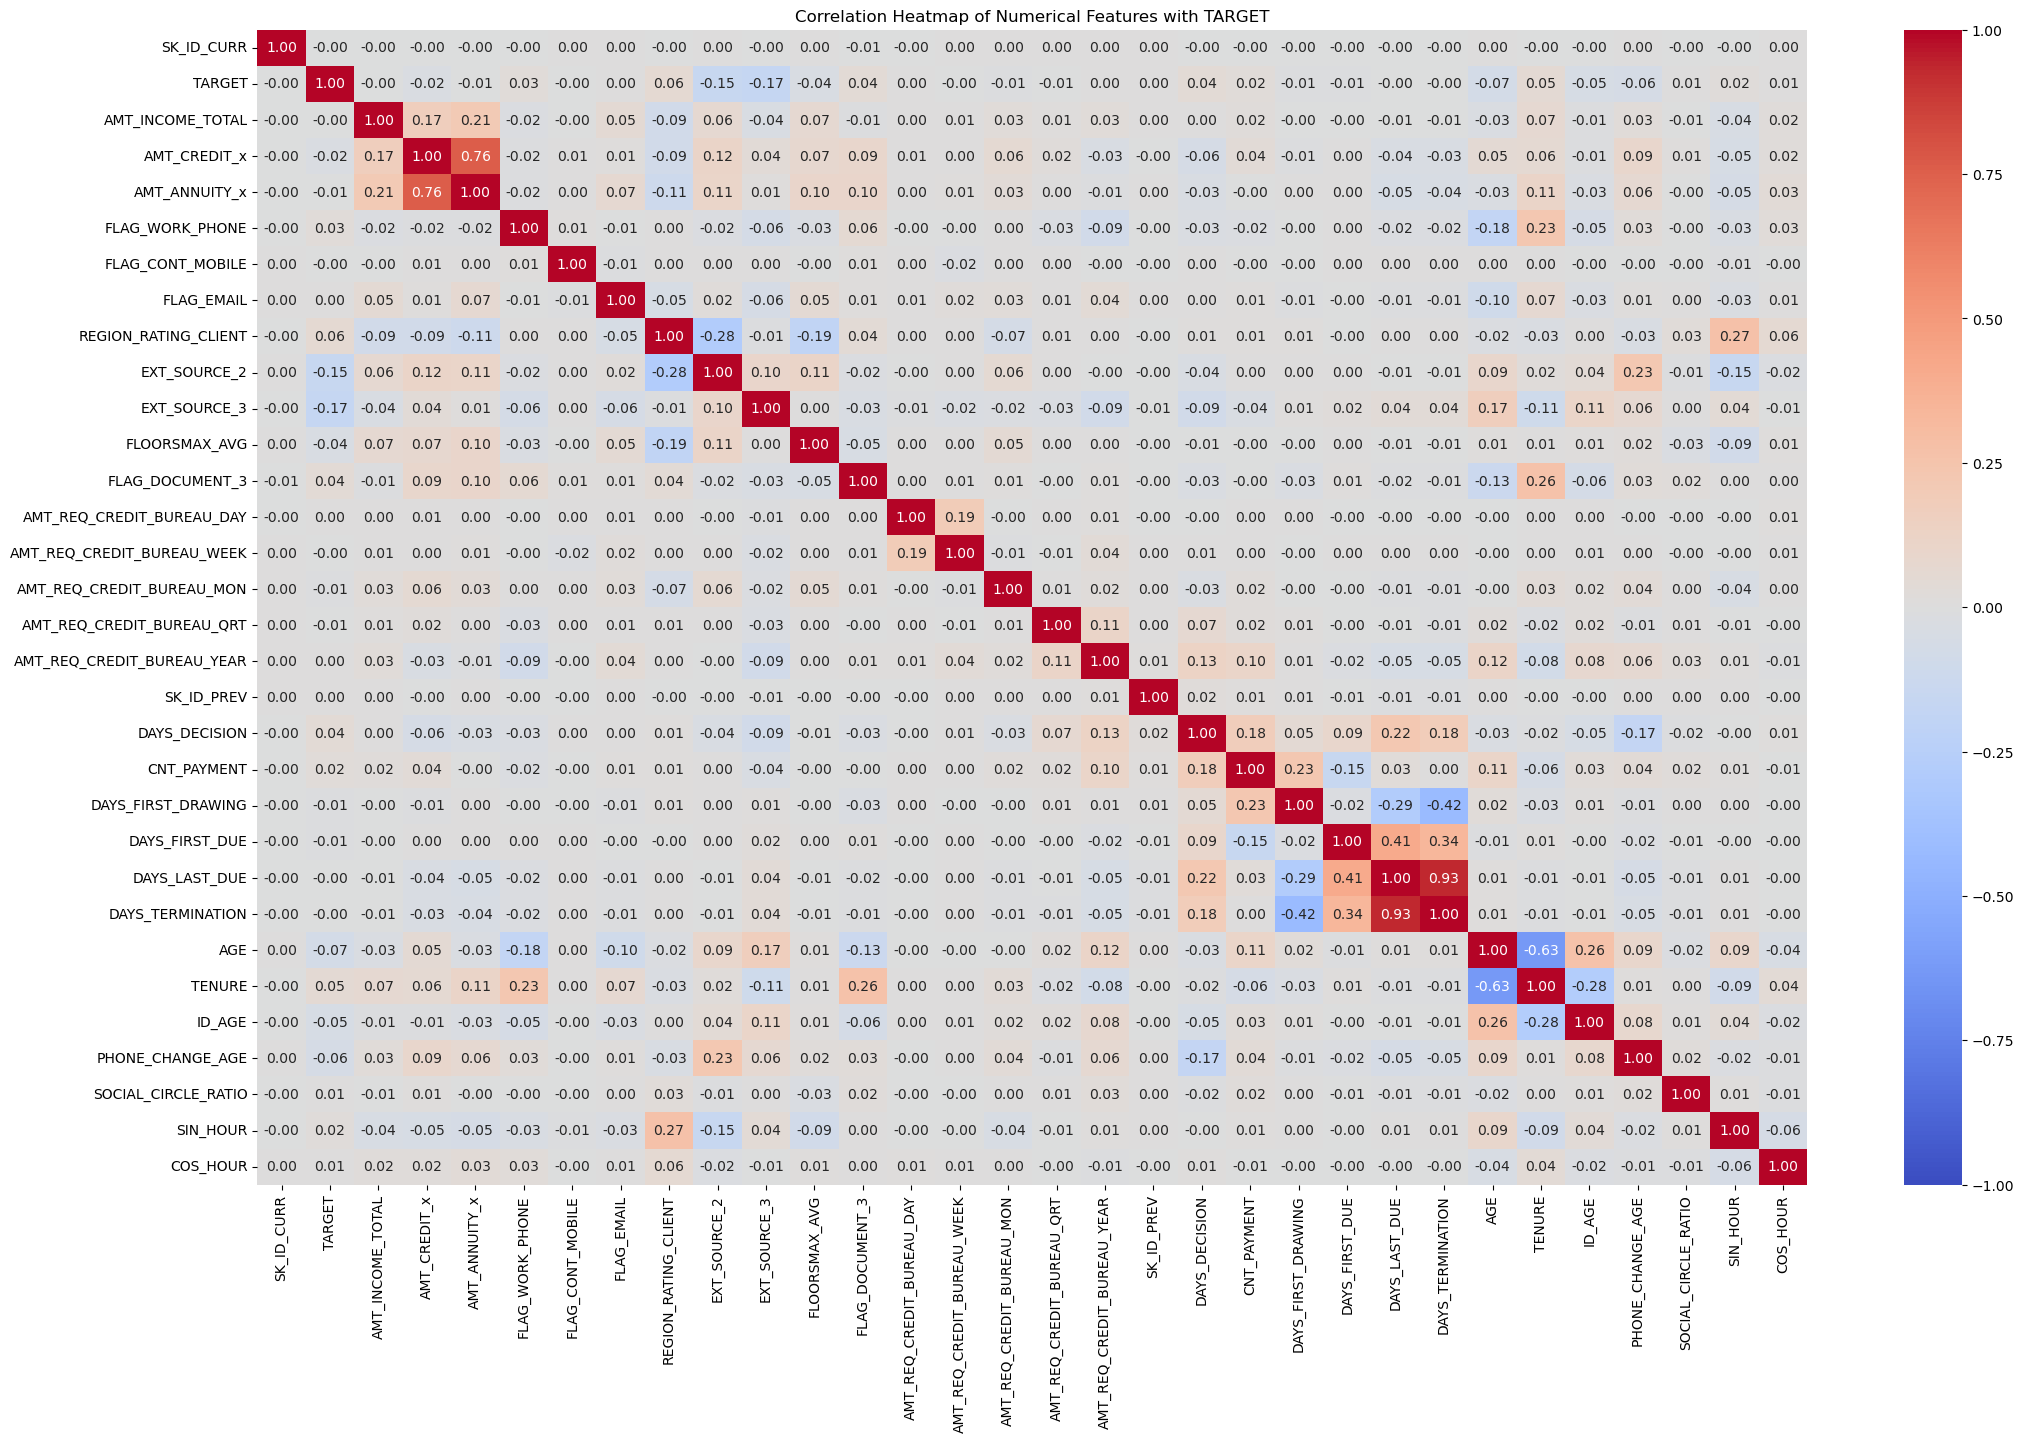

TARGET                        1.000000
REGION_RATING_CLIENT          0.056932
TENURE                        0.047804
FLAG_DOCUMENT_3               0.041918
DAYS_DECISION                 0.039901
FLAG_WORK_PHONE               0.028261
CNT_PAYMENT                   0.023689
SIN_HOUR                      0.020610
SOCIAL_CIRCLE_RATIO           0.007216
COS_HOUR                      0.005046
AMT_REQ_CREDIT_BUREAU_DAY     0.004027
AMT_REQ_CREDIT_BUREAU_YEAR    0.002091
FLAG_EMAIL                    0.002063
SK_ID_PREV                    0.002009
FLAG_CONT_MOBILE             -0.000059
AMT_REQ_CREDIT_BUREAU_WEEK   -0.000696
SK_ID_CURR                   -0.001246
AMT_INCOME_TOTAL             -0.002152
DAYS_LAST_DUE                -0.002257
DAYS_TERMINATION             -0.003288
AMT_REQ_CREDIT_BUREAU_QRT    -0.005179
AMT_ANNUITY_x                -0.007408
DAYS_FIRST_DUE               -0.010665
AMT_REQ_CREDIT_BUREAU_MON    -0.014592
DAYS_FIRST_DRAWING           -0.014967
AMT_CREDIT_x             

In [358]:
# Select only numeric columns (int and float) from the dataframe
numeric_cols = ss.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlation matrix for numeric columns with respect to 'TARGET'
corr_matrix = ss[numeric_cols].corr()

# Get the correlation of all columns with 'TARGET'
target_corr = corr_matrix['TARGET'].sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(25, 15))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Heatmap of Numerical Features with TARGET')
plt.show()

# Display the target correlations
print(target_corr)


In [360]:
ss.shape

(1413701, 53)

In [362]:
# Identify categorical columns
categorical_cols = ss.select_dtypes(include=['object']).columns.tolist()

# Identify continuous columns (numeric features)
continuous_cols = ss.select_dtypes(include=['int64', 'float64']).columns.tolist()

# You can also manually filter out columns that should not be treated as categorical or continuous
# For example, columns like "SK_ID_CURR" might be identifiers, so you can remove them from categorical/continuous lists
categorical_cols = [col for col in categorical_cols if col != 'SK_ID_CURR']
continuous_cols = [col for col in continuous_cols if col != 'SK_ID_CURR']

# Display the results
print("Categorical Columns:")
print(categorical_cols)

print("\nContinuous Columns:")
print(continuous_cols)


print(f"\nTotal number of categorical columns: {len(categorical_cols)}")
print(f"\nTotal number of continuous columns: {len(continuous_cols)}")

Categorical Columns:
[]

Continuous Columns:
['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMAX_AVG', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'SK_ID_PREV', 'DAYS_DECISION', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'AGE', 'TENURE', 'ID_AGE', 'PHONE_CHANGE_AGE', 'SOCIAL_CIRCLE_RATIO', 'SIN_HOUR', 'COS_HOUR']

Total number of categorical columns: 0

Total number of continuous columns: 31


In [364]:
ss.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                     0            1             0   
1      100003       0                     0            0             0   
2      100003       0                     0            0             0   
3      100003       0                     0            0             0   
4      100004       0                     1            1             1   

   FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY_x  \
0                1          202500.0      406597.5        24700.5   
1                0          270000.0     1293502.5        35698.5   
2                0          270000.0     1293502.5        35698.5   
3                0          270000.0     1293502.5        35698.5   
4                1           67500.0      135000.0         6750.0   

   NAME_INCOME_TYPE  ...  DAYS_FIRST_DUE  DAYS_LAST_DUE  DAYS_TERMINATION  \
0                 6  ...          -565.0          -25.0             -17.0   
1                 3  ...          -716.0         -536.0            -527.0   
2                 3  ...          -797.0         -647.0            -639.0   
3                 3  ...         -2310.0        -1980.0           -1976.0   
4                 6  ...          -784.0         -724.0            -714.0   

         AGE    TENURE    ID_AGE  PHONE_CHANGE_AGE  SOCIAL_CIRCLE_RATIO  \
0  25.920548  1.745205  5.808219          3.106849             0.666667   
1  45.931507  3.254795  0.797260          2.268493             1.000000   
2  45.931507  3.254795  0.797260          2.268493             1.000000   
3  45.931507  3.254795  0.797260          2.268493             1.000000   
4  52.180822  0.616438  6.934247          2.232877             0.000000   

   SIN_HOUR  COS_HOUR  
0  0.500000 -0.866025  
1  0.258819 -0.965926  
2  0.258819 -0.965926  
3  0.258819 -0.965926  
4  0.707107 -0.707107  

[5 rows x 53 columns]

In [366]:
# Save the 'ss' dataframe to a CSV file
ss.to_csv('final_data.csv', index=False)

print("Data saved to 'final_data.csv'")


Data saved to 'final_data.csv'


# OUTLIERS

In [380]:
ss.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x',
       'AMT_ANNUITY_x', 'NAME_INCOME_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'REGION_RATING_CLIENT', 'WEEKDAY_APPR_PROCESS_START_x',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMAX_AVG',
       'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_DOCUMENT_3',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'SK_ID_PREV',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'CNT_PAYMENT',
       'NAME_YIELD_GROUP', 'DAYS_FIRST_DRAWING', 'DAYS_FIR

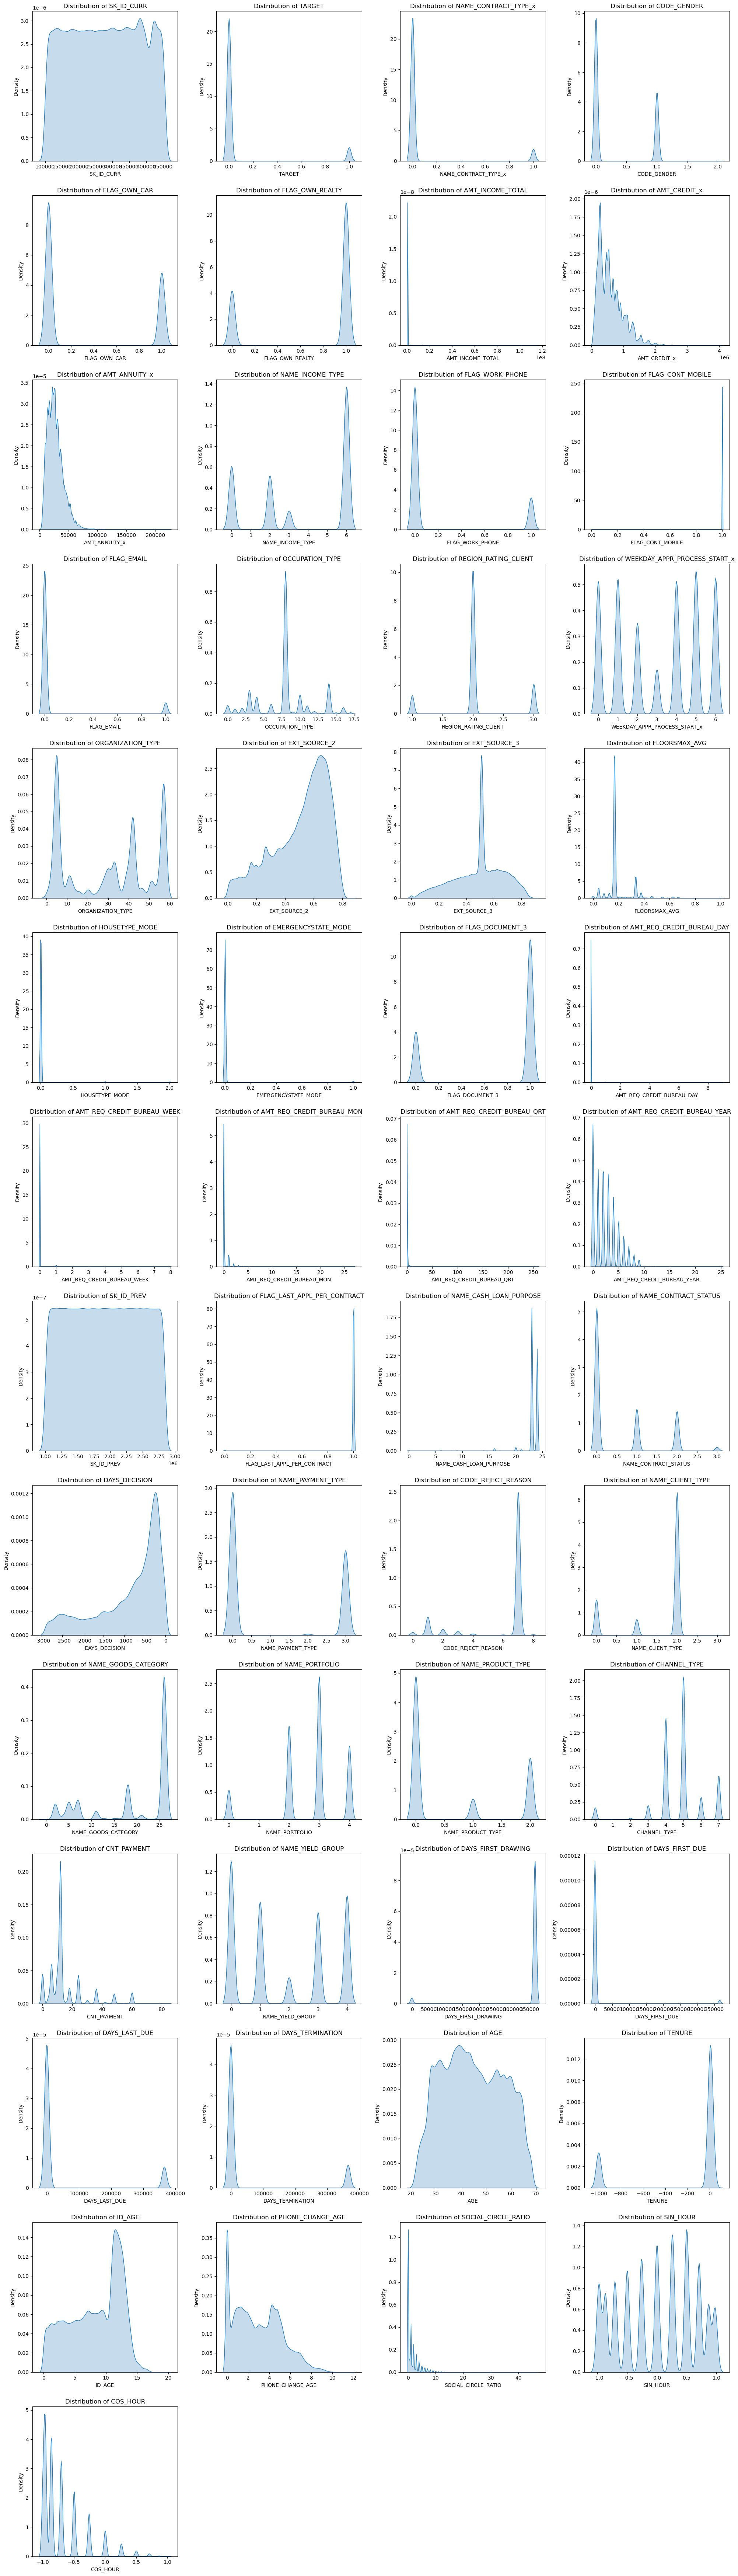

In [382]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Set the number of columns for the subplots grid
num_cols = 4
num_features = len(ss.columns)
num_rows = math.ceil(num_features / num_cols)

# Create the figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each feature on a subplot
for idx, col in enumerate(ss.columns):
    sns.kdeplot(ss[col], ax=axes[idx], fill=True)
    axes[idx].set_title(f"Distribution of {col}")
    axes[idx].set_xlabel(col)

# Remove empty subplots
for idx in range(num_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [404]:
original_categorical_columns = ['NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 
                                 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 
                                 'EMERGENCYSTATE_MODE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 
                                 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 
                                 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP']

# Display encoded columns
encoded_columns = [col for col in original_categorical_columns if col in ss.columns]
print("Label-encoded columns:", encoded_columns)


Label-encoded columns: ['NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_YIELD_GROUP']


# TREATING OUTLIERS

In [423]:
def impute_outliers(df, columns):
    for column in columns:
        # Calculate the bounds for each column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate the median of non-outlier values
        median_value = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)][column].median()

        # Replace outliers with the median
        df[column] = df[column].apply(
            lambda x: median_value if (x < lower_bound or x > upper_bound) else x
        )

        # Print the result for verification
        print(f"Outliers in '{column}' have been imputed with the median value: {median_value}")
    
    return df


# List of columns with outliers
columns_with_outliers = [
    'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL',
    'REGION_RATING_CLIENT', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMAX_AVG', 'FLAG_DOCUMENT_3',
    'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 
    'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_DECISION', 'CNT_PAYMENT',
    'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'TENURE',
    'ID_AGE', 'PHONE_CHANGE_AGE', 'SOCIAL_CIRCLE_RATIO'
]

# Impute outliers in the selected columns
ss = impute_outliers(ss, columns_with_outliers)


Outliers in 'AMT_CREDIT_x' have been imputed with the median value: 499171.5
Outliers in 'AMT_ANNUITY_x' have been imputed with the median value: 24592.5
Outliers in 'FLAG_WORK_PHONE' have been imputed with the median value: 0.0
Outliers in 'FLAG_CONT_MOBILE' have been imputed with the median value: 1.0
Outliers in 'FLAG_EMAIL' have been imputed with the median value: 0.0
Outliers in 'REGION_RATING_CLIENT' have been imputed with the median value: 2.0
Outliers in 'EXT_SOURCE_2' have been imputed with the median value: 0.5627679142553595
Outliers in 'EXT_SOURCE_3' have been imputed with the median value: 0.5100895276257282
Outliers in 'FLOORSMAX_AVG' have been imputed with the median value: 0.1667
Outliers in 'FLAG_DOCUMENT_3' have been imputed with the median value: 1.0
Outliers in 'AMT_REQ_CREDIT_BUREAU_DAY' have been imputed with the median value: 0.0
Outliers in 'AMT_REQ_CREDIT_BUREAU_WEEK' have been imputed with the median value: 0.0
Outliers in 'AMT_REQ_CREDIT_BUREAU_MON' have been

In [415]:
ss.shape

(1413701, 53)

In [419]:
# After imputing outliers, you can check the first few rows to verify the changes
print(ss.head())  # Check the first few rows

# Or check the summary statistics
print(ss.describe())  # To verify the statistics after outlier imputation


   SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE_x  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                     0            1             0   
1      100003       0                     0            0             0   
2      100003       0                     0            0             0   
3      100003       0                     0            0             0   
4      100004       0                     1            1             1   

   FLAG_OWN_REALTY  AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY_x  \
0                1          202500.0      406597.5        24700.5   
1                0          270000.0     1293502.5        35698.5   
2                0          270000.0     1293502.5        35698.5   
3                0          270000.0     1293502.5        35698.5   
4                1           67500.0      135000.0         6750.0   

   NAME_INCOME_TYPE  ...  DAYS_FIRST_DUE  DAYS_LAST_DUE  DAYS_TERMINATION  \
0                 6  ...          -565.0          -25.0        

In [429]:
ss.isnull().sum()

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE_x            0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
AMT_INCOME_TOTAL                0
AMT_CREDIT_x                    0
AMT_ANNUITY_x                   0
NAME_INCOME_TYPE                0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
REGION_RATING_CLIENT            0
WEEKDAY_APPR_PROCESS_START_x    0
ORGANIZATION_TYPE               0
EXT_SOURCE_2                    0
EXT_SOURCE_3                    0
FLOORSMAX_AVG                   0
HOUSETYPE_MODE                  0
EMERGENCYSTATE_MODE             0
FLAG_DOCUMENT_3                 0
AMT_REQ_CREDIT_BUREAU_DAY       0
AMT_REQ_CREDIT_BUREAU_WEEK      0
AMT_REQ_CREDIT_BUREAU_MON       0
AMT_REQ_CREDIT_BUREAU_QRT       0
AMT_REQ_CREDIT_BUREAU_YEAR      0
SK_ID_PREV                      0
FLAG_LAST_APPL

In [439]:
# Save the 'ss' dataframe to a CSV file
ss.to_csv('ff.csv', index=False)

print("Data saved to 'ff.csv'")

Data saved to 'ff.csv'
